In [1]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, labels in loader:
        targets = labels
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        #losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):

    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

@torch.no_grad()
def evaluation(model, data_loader):
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in data_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)  # Use the passed model argument here
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Use data_loader's dataset length for normalization
        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_loss = round(epoch_loss, 3)
        epoch_acc = running_corrects.item() / len(data_loader.dataset)

        return {'Loss': epoch_loss, 'Acc': epoch_acc}

In [98]:
def relearn_time(model, train_loader, valid_loader, reqAcc, lr):
    # Measuring relearn time for gold standard model
    rltime = 0
    curr_Acc = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # We will try the relearning step till 10 epochs.
    for epoch in range(10):
        for batch in train_loader:
            model.train()
            loss = training_step(model, batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            history = [evaluation(model, valid_loader)]
            curr_Acc = history[0]["Acc"] * 100
            print(curr_Acc, sep=',')
            
            rltime += 1
            if curr_Acc >= reqAcc:
                break
                
        if curr_Acc >= reqAcc:
            break
    return rltime

In [4]:
path = "./"

In [5]:
identities = {}

# (Image File Name, Subject Identity Information)
with open(path + 'CelebA-HQ-identity.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        identities[file_name] = identity

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

There are 6217 identities.
There are 30000 images.


# Choose Single Label to Use
"male": 21,
"smiling": 32,
"young": 40

In [6]:
label_map = {}

label_num = 40  # "male": 21, "smiling": 32, "young": 40

with open(path + 'CelebA-HQ-attribute.txt') as f:
    lines = f.readlines()
    for line in lines[2:]:
        splited = line.strip().split()
        file_name, label = splited[0], splited[label_num]
        label_map[file_name] = label

print(f'There are {len(set(label_map.values()))} classes.')
print(f'There are {len(label_map.keys())} images.')

There are 2 classes.
There are 30000 images.


In [7]:
source_root = path + 'CelebAMask-HQ\CelebAMask-HQ\CelebA-HQ-img'

train_index = 190
retain_index = 1250
unseen_index = 4855

Number of identities: 30000
Sample identities: [('0.jpg', '0'), ('1.jpg', '1'), ('2.jpg', '2'), ('3.jpg', '3'), ('4.jpg', '4')]
Number of labels: 30000
Sample labels: [('0.jpg', '1'), ('1.jpg', '1'), ('2.jpg', '1'), ('3.jpg', '1'), ('4.jpg', '1')]


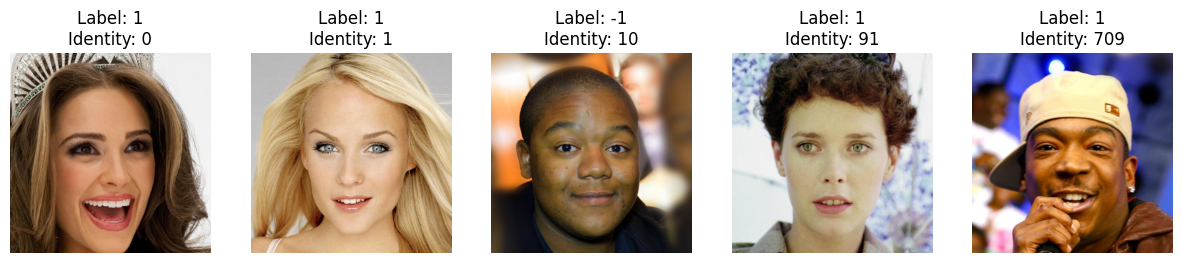

In [8]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Verify identities dictionary
print(f'Number of identities: {len(identities)}')
print(f'Sample identities: {list(identities.items())[:5]}')

# Verify label_map dictionary
print(f'Number of labels: {len(label_map)}')
print(f'Sample labels: {list(label_map.items())[:5]}')

# Display a few images with their labels and identities
def display_images_with_labels(image_paths, labels, identities, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(image_paths[:num_images]):
        try:
            image = Image.open(image_path).convert("RGB")
            file_name = os.path.basename(image_path)
            label = labels.get(file_name, "Unknown")
            identity = identities.get(file_name, "Unknown")

            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {label}\nIdentity: {identity}')
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    plt.show()

# Collect some sample image paths
sample_image_paths = glob.glob(os.path.join(source_root, "*"))

# Display sample images
if sample_image_paths:
    display_images_with_labels(sample_image_paths, label_map, identities, num_images=5)
else:
    print("No images found in the specified directory.")

In [9]:
#print(f'Source root directory: {source_root}')

In [10]:
import os

# List the contents of the source root directory
#print("Listing contents of the source root directory:")
# for file_name in os.listdir(source_root):
#     print(file_name)

# Also print the full paths of a few files to verify
sample_image_paths = glob.glob(os.path.join(source_root, "*"))
#print("Sample image paths:")
#print(sample_image_paths[:5])


In [11]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        
        
        # Print sample image paths
        #print(f'Sample image paths: {self.image_path_list[:5]}')

        for image_path in self.image_path_list:
            file_name = os.path.basename(image_path)  # Use basename to get just the filename
            if file_name in identities:
                identity = int(identities[file_name])
                if identity >= train_index and identity < unseen_index:
                    label = int(label_map[file_name])
                    if label == -1:
                        label = 0
                    self.labels.append((label, identity))
                    self.image_paths.append(image_path)
            else:
                print(f"File {file_name} not found in identities dictionary.")

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx][0]

        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(label)

        return image, label

In [12]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = os.path.basename(image_path)
            if file_name in identities:
                identity = int(identities[file_name])
                if identity < train_index:
                    label = int(label_map[file_name])
                    if label == -1:
                        label = 0
                    self.labels.append((label, identity))
                    self.image_paths.append(image_path)
                
                    # print(f"Ignoring {file_name} with identity {identity} as it does not meet test criteria.")
            else:
                print(f"File {file_name} not found in identities dictionary. Check for case sensitivity or path differences.")

        print(f'TestDataset: {len(self.image_paths)} images')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx][0]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

In [13]:
class ForgetDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = os.path.basename(image_path)
            if file_name in identities:
                identity = int(identities[file_name])
                if identity >= train_index and identity < retain_index:
                    label = int(label_map[file_name])
                    if label == -1:
                        label = 0
                    self.labels.append((label, identity))
                    self.image_paths.append(image_path)
                
                    # print(f"Ignoring {file_name} with identity {identity} as it does not meet forget criteria.")
            else:
                print(f"File {file_name} not found in identities dictionary. Check for case sensitivity or path differences.")

        print(f'ForgetDataset: {len(self.image_paths)} images')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx][0]

        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(label)

        return image, label

In [14]:
class RetainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = os.path.basename(image_path)
            if file_name in identities:
                identity = int(identities[file_name])
                if identity < unseen_index and identity >= retain_index:
                    label = int(label_map[file_name])
                    if label == -1:
                        label = 0
                    self.labels.append((label, identity))
                    self.image_paths.append(image_path)
                
                    # print(f"Ignoring {file_name} with identity {identity} as it does not meet retain criteria.")
            else:
                print(f"File {file_name} not found in identities dictionary. Check for case sensitivity or path differences.")

        print(f'RetainDataset: {len(self.image_paths)} images')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx][0]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

In [15]:
class UnseenDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        
        for image_path in self.image_path_list:
            file_name = os.path.basename(image_path)
            if file_name in identities:
                identity = int(identities[file_name])
                if identity >= unseen_index:
                    label = int(label_map[file_name])
                    if label == -1:
                        label = 0
                    self.labels.append((label, identity))
                    self.image_paths.append(image_path)
                
                    # print(f"Ignoring {file_name} with identity {identity} as it does not meet unseen criteria.")
            else:
                print(f"File {file_name} not found in identities dictionary. Check for case sensitivity or path differences.")

        print(f'UnseenDataset: {len(self.image_paths)} images')


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx][0]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

In [16]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_set = TrainDataset(transform=train_transform)
test_set = TestDataset(transform=test_transform)
forget_set_train = ForgetDataset(transform=train_transform)
forget_set_test = ForgetDataset(transform=test_transform)
retain_set_train = RetainDataset(transform=train_transform)
retain_set_test = RetainDataset(transform=test_transform)
unseen_set = UnseenDataset(transform=unseen_transform)

TestDataset: 2065 images
ForgetDataset: 10183 images
ForgetDataset: 10183 images
RetainDataset: 15750 images
RetainDataset: 15750 images
UnseenDataset: 2002 images


In [17]:
print('Train dataset size:', len(train_set))
print('Test dataset size:', len(test_set))
print('Forget dataset size:', len(forget_set_train))
print('Retain dataset size:', len(retain_set_train))
print('Unseen dataset size:', len(unseen_set))

Train dataset size: 25933
Test dataset size: 2065
Forget dataset size: 10183
Retain dataset size: 15750
Unseen dataset size: 2002


In [18]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=24, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=24, shuffle=False, num_workers=0, pin_memory=True)
forget_dataloader_train = torch.utils.data.DataLoader(forget_set_train, batch_size=24, shuffle=True, num_workers=0, pin_memory=True)
forget_dataloader_test = torch.utils.data.DataLoader(forget_set_test, batch_size=24, shuffle=False, num_workers=0, pin_memory=True)
retain_dataloader_train = torch.utils.data.DataLoader(retain_set_train, batch_size=24, shuffle=True, num_workers=0, pin_memory=True)
retain_dataloader_test = torch.utils.data.DataLoader(retain_set_test, batch_size=24, shuffle=False, num_workers=0,pin_memory=True)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=24, shuffle=False, num_workers=0, pin_memory=True)

In [19]:
train_image_paths = TrainDataset().image_paths
test_image_paths = TestDataset().image_paths
forget_image_paths = ForgetDataset().image_paths
retain_image_paths = RetainDataset().image_paths
unseen_image_paths = UnseenDataset().image_paths

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

TestDataset: 2065 images
ForgetDataset: 10183 images
RetainDataset: 15750 images
UnseenDataset: 2002 images


{'train_test': 0,
 'train_forget': 10183,
 'train_retain': 15750,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

# Image Visualization

In [20]:
if label_num == 21:
    label_convert = {0: "F", 1: "M"}
elif label_num == 32:
    label_convert = {0: "unsmiling", 1: "smiling"}
if label_num == 40:
    label_convert = {0: "old", 1: "young"}

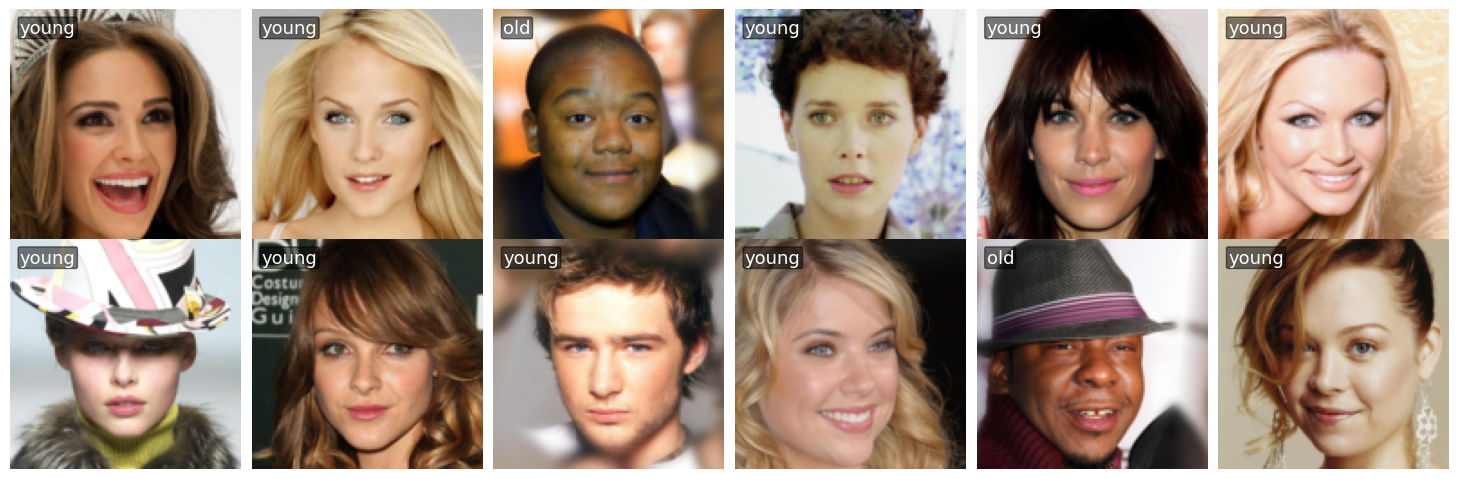

In [21]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_convert[label.item()] for label in labels[0:12]]

show_images(imgs[0:12], label_strs, nrow=6)

# Train the "Original Model"
Train the Original model to serve as the base model for performing Machine Unlearning

In [22]:
learning_rate = 0.01
log_step = 30

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [23]:
def train(model, dataloader):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step = 20

    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.size(0)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += torch.sum(preds == labels)

        if (i + 1) % log_step == 0:
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch: {i + 1}] running train loss: {current_loss:.4f}, running train accuracy: {current_acc:.4f}')

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'train loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}')
    print("elapsed time:", time.time() - start_time)
    return epoch_loss, epoch_acc.item()


def test(model, dataloader):
    start_time = time.time()
    print('[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step=20

    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.size(0)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += torch.sum(preds == labels)

        if (i == 0) or ((i + 1) % log_step == 0):
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch: {i + 1}] running test loss: {current_loss:.4f}, running test accuracy: {current_acc:.4f}')

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'test loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}')
    print("elapsed time:", time.time() - start_time)
    return epoch_loss, epoch_acc.item()

In [24]:
import torch
import time

# Check if GPU is available and use it if possible
if torch.cuda.is_available():
    model.cuda()
    print("Using GPU")
else:
    print("GPU not available, using CPU")

# Run the training loop for a single batch to debug data loaders and model
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    inputs, targets = inputs.cuda(), targets.cuda()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    print(f"Batch {batch_idx + 1}, Loss: {loss.item()}")
    break  # Run for one batch only to debug

Using GPU
Batch 1, Loss: 1.1375974416732788


In [25]:
num_original_epochs = 10
best_test_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_original_epochs):
    start_time = time.time()
    train_loss, train_acc = train(model, train_dataloader)
    train_time = time.time() - start_time
    
    start_time = time.time()
    test_loss, test_acc = test(model, test_dataloader)
    test_time = time.time() - start_time
    
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

    if test_acc > best_test_acc:
        print("[Info] best test accuracy!")
        best_test_acc = test_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}_gender.pth')

    print(f'Epoch {epoch + 1}, Train Time: {train_time:.2f}s, Test Time: {test_time:.2f}s')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_original_epochs}_gender.pth')

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.8142, running train accuracy: 0.6500
[Batch: 40] running train loss: 0.7238, running train accuracy: 0.6833
[Batch: 60] running train loss: 0.6559, running train accuracy: 0.7208
[Batch: 80] running train loss: 0.7053, running train accuracy: 0.7125
[Batch: 100] running train loss: 0.7266, running train accuracy: 0.7133
[Batch: 120] running train loss: 0.7106, running train accuracy: 0.7118
[Batch: 140] running train loss: 0.6895, running train accuracy: 0.7193
[Batch: 160] running train loss: 0.6767, running train accuracy: 0.7227
[Batch: 180] running train loss: 0.6638, running train accuracy: 0.7229
[Batch: 200] running train loss: 0.6648, running train accuracy: 0.7217
[Batch: 220] running train loss: 0.6641, running train accuracy: 0.7184
[Batch: 240] running train loss: 0.6765, running train accuracy: 0.7200
[Batch: 260] running train loss: 0.6774, running train accuracy: 0.7175
[Batch: 280] running train loss: 0.6648, runni

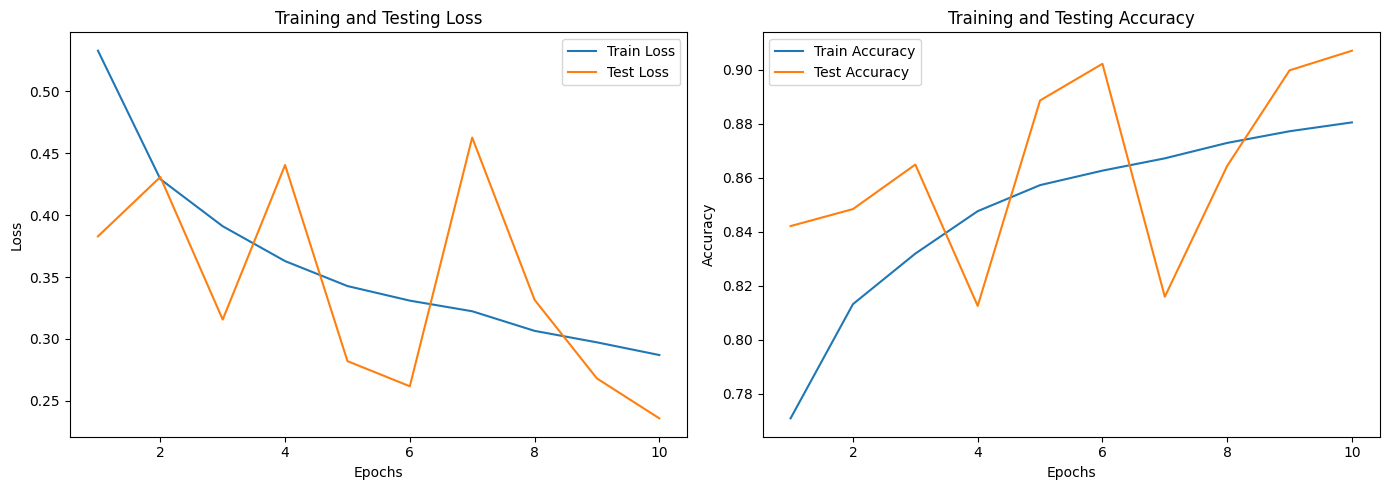

In [26]:
import matplotlib.pyplot as plt

train_losses, test_losses = zip(*history)
train_accuracies, test_accuracies = zip(*accuracy)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# Final Test

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}_gender.pth' # If you trian the original model from scratch.
model_path = f'pre_trained_checkpoint_y.pth'  # downloaded model
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = test(model, test_dataloader)
print("test loss:", test_loss)
print("test acc:", test_acc)

[Test]
[Batch: 1] running test loss: 0.2631, running test accuracy: 0.9167
[Batch: 20] running test loss: 0.2494, running test accuracy: 0.9062
[Batch: 40] running test loss: 0.2501, running test accuracy: 0.9073
[Batch: 60] running test loss: 0.2405, running test accuracy: 0.9104
[Batch: 80] running test loss: 0.2383, running test accuracy: 0.9073
test loss: 0.2333, accuracy: 0.9090
elapsed time: 19.2988498210907
test loss: 0.23325381058180303
test acc: 0.908958837772397


In [28]:
retrained_model = models.resnet18(pretrained=False)
num_features = retrained_model.fc.in_features
retrained_model.fc = nn.Linear(num_features, 2)
retrained_model = retrained_model.cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(retrained_model.parameters(), lr=0.001)

In [29]:
# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU")
else:
    print("GPU not available, using CPU")

# Run the training loop for a single batch to debug data loaders and model
for batch_idx, (inputs, targets) in enumerate(retain_dataloader_train):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = retrained_model(inputs)
    loss = criterion(outputs, targets)
    print(f"Batch {batch_idx + 1}, Loss: {loss.item()}")
    break  # Run for one batch only to debug

Using GPU
Batch 1, Loss: 0.5246829986572266


In [30]:
# Monitor resource usage
def print_resource_usage():
    # Get GPU memory usage
    if torch.cuda.is_available():
        gpu_mem_alloc = torch.cuda.memory_allocated() / (1024 ** 2)
        gpu_mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {gpu_mem_alloc:.2f} MB")
        print(f"GPU Memory Reserved: {gpu_mem_reserved:.2f} MB")
    
    # Get CPU memory usage
    mem = psutil.virtual_memory()
    mem_used = mem.used / (1024 ** 2)
    mem_available = mem.available / (1024 ** 2)
    print(f"CPU Memory Used: {mem_used:.2f} MB")
    print(f"CPU Memory Available: {mem_available:.2f} MB")
    
    # Get CPU usage
    cpu_usage = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_usage:.2f}%")


In [31]:
learning_rate = 0.01
best_test_acc = 0
best_epoch = 0

history = []
accuracy = []
num_original_epochs = 10
for epoch in range(num_original_epochs):
    train_loss, train_acc = train(retrained_model, retain_dataloader_train)
    test_loss, test_acc = test(retrained_model, test_dataloader)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.5626, running train accuracy: 0.7542
[Batch: 40] running train loss: 0.5665, running train accuracy: 0.7479
[Batch: 60] running train loss: 0.5763, running train accuracy: 0.7375
[Batch: 80] running train loss: 0.5742, running train accuracy: 0.7391
[Batch: 100] running train loss: 0.5744, running train accuracy: 0.7392
[Batch: 120] running train loss: 0.5732, running train accuracy: 0.7403
[Batch: 140] running train loss: 0.5694, running train accuracy: 0.7435
[Batch: 160] running train loss: 0.5680, running train accuracy: 0.7440
[Batch: 180] running train loss: 0.5632, running train accuracy: 0.7481
[Batch: 200] running train loss: 0.5637, running train accuracy: 0.7479
[Batch: 220] running train loss: 0.5652, running train accuracy: 0.7460
[Batch: 240] running train loss: 0.5626, running train accuracy: 0.7472
[Batch: 260] running train loss: 0.5612, running train accuracy: 0.7481
[Batch: 280] running train loss: 0.5607, runni

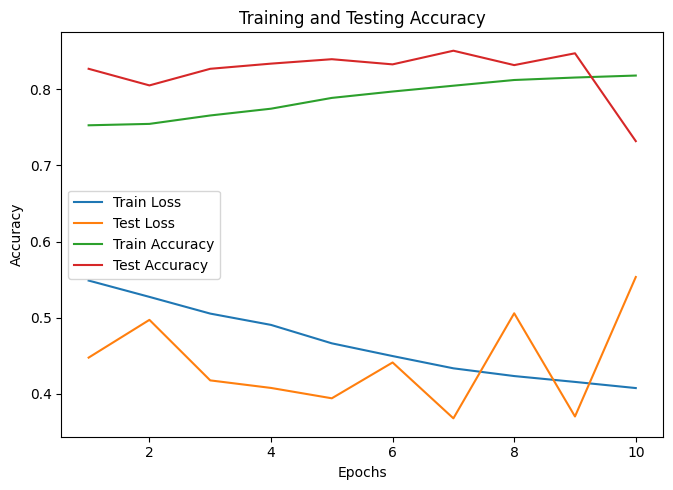

In [32]:
import matplotlib.pyplot as plt

train_losses, test_losses = zip(*history)
train_accuracies, test_accuracies = zip(*accuracy)

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & testing accuracieplt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
test_acc = evaluation(retrained_model, test_dataloader)
unseen_acc = evaluation(retrained_model, unseen_dataloader)
mia = cal_mia(retrained_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


Test Acc: {'Loss': 0.553, 'Acc': 0.7317191283292979}
Unseen Acc: {'Loss': 0.688, 'Acc': 0.6193806193806194}
MIA: {'MIA': 0.5361596009975063, 'Forgeting Score': 0.03615960099750626}
Final Score: 0.8296999631671427


In [90]:
# Function to calculate HTER
def calculate_hter(y_true, y_pred):
    fpr, fnr = calculate_fpr_fnr(y_true, y_pred)
    hter = 0.5 * (fpr + fnr)
    return hter

# Get predictions and true labels
y_true, y_pred = get_predictions(retrained_model, test_dataloader)

# Calculate HTER
hter = calculate_hter(y_true, y_pred)
print(f'HTER: {hter}')


HTER: 0.3629118657130395


In [114]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Relearn Time 
def training_step(model, batch):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer.step()
    return loss.item()  

def calculate_acc(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0) * 100

def relearn_time(model, train_loader, valid_loader, reqAcc, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()  # Define your criterion here
    epochs = 0
    valid_accuracy = 0.0  # Initialize valid_accuracy
    while valid_accuracy < reqAcc:
        epochs += 1
        train_loss = 0.0
        model.train()
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validate every epoch
        model.eval()
        valid_corrects = 0
        total = 0
        with torch.no_grad():
            for batch in valid_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                valid_corrects += torch.sum(preds == labels).item()
                total += labels.size(0)

        valid_accuracy = (valid_corrects / total) * 100

    return epochs


#Relearn time function
reqAcc = 73
lr = 0.001  
original_model.to(device)
rltime = relearn_time(retrained_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
print(f'Relearn time: {rltime} epochs')

Relearn time: 1 epochs


In [116]:
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
JSZRF = compute_ZRF_JS_score(retrained_model, model, forget_dataloader_test, device)
print(JSZRF)

{'JS_Divergence': 0.10257095098495483, 'ZRF_Score': 0.8974290490150452}


In [117]:
# Evaluate your model on the worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)
evaluation_results = evaluation(retrained_model, worst_case_forget_loader)

In [118]:
print("Evaluation on worst-case forget set:", evaluation_results)

Evaluation on worst-case forget set: {'Loss': 0.465, 'Acc': 0.84}


In [36]:
def compute_influence_scores(model, dataloader, criterion):
    influence_scores = []
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Compute gradients
        grads = grad(loss, model.parameters(), create_graph=True)
        
        # Compute influence score (sum of squared gradients)
        influence_score = sum((g**2).sum() for g in grads).item()
        influence_scores.append(influence_score)
        
    return influence_scores

influence_scores = compute_influence_scores(model, train_dataloader, criterion)

# Rank data points by influence scores
worst_case_indices = sorted(range(len(influence_scores)), key=lambda i: influence_scores[i], reverse=True)

# Select top k worst-case forget sets
k = 100  # Adjust as needed
worst_case_forget_set = [train_set[i] for i in worst_case_indices[:k]]

In [37]:
# Check if GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the pre-trained model
original_save_path = 'pre_trained_checkpoint_y.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 2)
unlearned_model.load_state_dict(torch.load(original_save_path, map_location=device))
unlearned_model = unlearned_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

Using device: cuda


In [38]:
# Unlearning by pruning weights related to forget set
def prune_weights(model, forget_dataloader):
    model.eval()
    with torch.no_grad():
        for imgs, labels in forget_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            for layer in model.children():
                if hasattr(layer, 'weight'):
                    layer.weight.data.zero_()
                if hasattr(layer, 'bias') and layer.bias is not None:
                    layer.bias.data.zero_()
    return model

# Prune the weights
unlearned_model = prune_weights(unlearned_model, forget_dataloader_train)

In [39]:
# Train the pruned model on retain set
num_epochs = 2
print_every = 20
dataloader_iterator = iter(forget_dataloader_train)
for epoch in range(num_epochs):
    running_loss = 0
    unlearned_model.train()

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.to(device)
        labels = labels.to(device)

        try:
            (x_forget, y_forget) = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(forget_dataloader_train)
            (x_forget, y_forget) = next(dataloader_iterator)

        if x_forget.size(0) != imgs.size(0):
            continue

        outputs_forget = unlearned_model(x_forget.to(device))
        loss_ascent_forget = -criterion(outputs_forget, y_forget.to(device))

        optimizer.zero_grad()
        loss_ascent_forget.backward()
        optimizer.step()

        running_loss += loss_ascent_forget.item() * imgs.size(0)
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss_ascent_forget.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * imgs.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

Epoch [1/2], Batch [20/657] - Batch Loss: -7.1294
Epoch [1/2], Batch [40/657] - Batch Loss: -14.4808
Epoch [1/2], Batch [60/657] - Batch Loss: -29.3073
Epoch [1/2], Batch [80/657] - Batch Loss: -54.9915
Epoch [1/2], Batch [100/657] - Batch Loss: -71.9036
Epoch [1/2], Batch [120/657] - Batch Loss: -99.5107
Epoch [1/2], Batch [140/657] - Batch Loss: -113.3405
Epoch [1/2], Batch [160/657] - Batch Loss: -169.5308
Epoch [1/2], Batch [180/657] - Batch Loss: -174.9707
Epoch [1/2], Batch [200/657] - Batch Loss: -224.5696
Epoch [1/2], Batch [220/657] - Batch Loss: -210.5903
Epoch [1/2], Batch [240/657] - Batch Loss: -251.4643
Epoch [1/2], Batch [260/657] - Batch Loss: -311.3988
Epoch [1/2], Batch [280/657] - Batch Loss: -374.8299
Epoch [1/2], Batch [300/657] - Batch Loss: -324.5827
Epoch [1/2], Batch [320/657] - Batch Loss: -395.3258
Epoch [1/2], Batch [340/657] - Batch Loss: -452.8859
Epoch [1/2], Batch [360/657] - Batch Loss: -515.5114
Epoch [1/2], Batch [380/657] - Batch Loss: -432.0411
Epoc

In [40]:
# Evaluate the unlearned model
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.to(device))

print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Loss': 8255.034, 'Acc': 0.17336561743341405}
Unseen Acc: {'Loss': 7591.996, 'Acc': 0.23976023976023977}
MIA: {'MIA': 0.5206982543640898, 'Forgeting Score': 0.020698254364089785}
Final Score: 0.5659845543526172


In [41]:
#Evaluating Unlearning Algorithm on Worst-Case Forget Sets

In [42]:
# Create DataLoader for worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)

# Evaluate your unlearning model on the worst-case forget set
evaluation_results = evaluation(unlearned_model, worst_case_forget_loader)
print("Evaluation on worst-case forget set:", evaluation_results)

Evaluation on worst-case forget set: {'Loss': 8389.328, 'Acc': 0.16}


In [73]:
# Evaluate the unlearned model
test_acc_unlearned = calculate_accuracy(unlearned_model, test_dataloader)
retain_acc_unlearned = calculate_accuracy(unlearned_model, retain_dataloader_train)
unseen_acc_unlearned = calculate_accuracy(unlearned_model, unseen_dataloader)
mia_unlearned, forgetting_score_unlearned = get_mia_metrics(unlearned_model)

print(f'Test Acc (Unlearned): {test_acc_unlearned}')
print(f'Retain Acc (Unlearned): {retain_acc_unlearned}')
print(f'Unseen Acc (Unlearned): {unseen_acc_unlearned}')
print(f'MIA (Unlearned): {mia_unlearned}')
print(f'Final Score (Unlearned): {(test_acc_unlearned + (1 - abs(mia_unlearned - 0.5) * 2)) / 2}')

# Evaluate the retain model
test_acc_retrained = calculate_accuracy(retrained_model, test_dataloader)
retain_acc_retrained = calculate_accuracy(retrained_model, retain_dataloader_train)
unseen_acc_retrained = calculate_accuracy(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)

print(f'Test Acc (Retained): {test_acc_retrained}')
print(f'Retain Acc (Retained): {retain_acc_retrained}')
print(f'Unseen Acc (Retained): {unseen_acc_retrained}')
print(f'MIA (Retained): {mia_retrained}')
print(f'Final Score (Retained): {(test_acc_retrained + (1 - abs(mia_retrained - 0.5) * 2)) / 2}')


# Calculate DP metrics for unlearned model
preds_unlearned, labels_unlearned = get_predictions(unlearned_model, test_dataloader)
fpr_unlearned, fnr_unlearned = calculate_fpr_fnr(labels_unlearned, preds_unlearned)
FPR_list_unlearned = [fpr_unlearned]
FNR_list_unlearned = [fnr_unlearned]

# Compute forgetting score for unlearned model
results_unlearned = compute_forgetting_score(FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained)
print("Forgetting Quality (Unlearned):", results_unlearned)

# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]

# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)
print("Forgetting Score (Retained):", results_retrained)

Test Acc (Unlearned): 0.17336561743341405
Retain Acc (Unlearned): 0.24755555555555556
Unseen Acc (Unlearned): 0.23976023976023977
MIA (Unlearned): 0.5206982543640898
Final Score (Unlearned): 0.5659845543526172
Test Acc (Retained): 0.7317191283292979
Retain Acc (Retained): 0.6881904761904762
Unseen Acc (Retained): 0.6193806193806194
MIA (Retained): 0.5361596009975063
Final Score (Retained): 0.8296999631671427
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.24755555555555556
RA^R: 0.6881904761904762
TA^U: 0.17336561743341405
TA^R: 0.7317191283292979
Forgeting Quality: 0.17045611146698056
Forgetting Quality (Unlearned): {'Epsilon Values': [0], 'H Values': [2.0], 'F Value': 2.0, 'RA^U': 0.24755555555555556, 'RA^R': 0.6881904761904762, 'TA^U': 0.17336561743341405, 'TA^R': 0.7317191283292979, 'Forgeting Quality': 0.17045611146698056}
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.7317191283292979
TA^R: 0.73

Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.826634382566586
TA^R: 0.826634382566586
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.24755555555555556
RA^R: 0.6881904761904762
TA^U: 0.17336561743341405
TA^R: 0.826634382566586
Forgeting Quality: 0.15088411507124055
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.826634382566586
TA^R: 0.826634382566586
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.24755555555555556
RA^R: 0.6881904761904762
TA^U: 0.17336561743341405
TA^R: 0.826634382566586
Forgeting Quality: 0.15088411507124055
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.826634382566586
TA^R: 0.826634382566586
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.2475

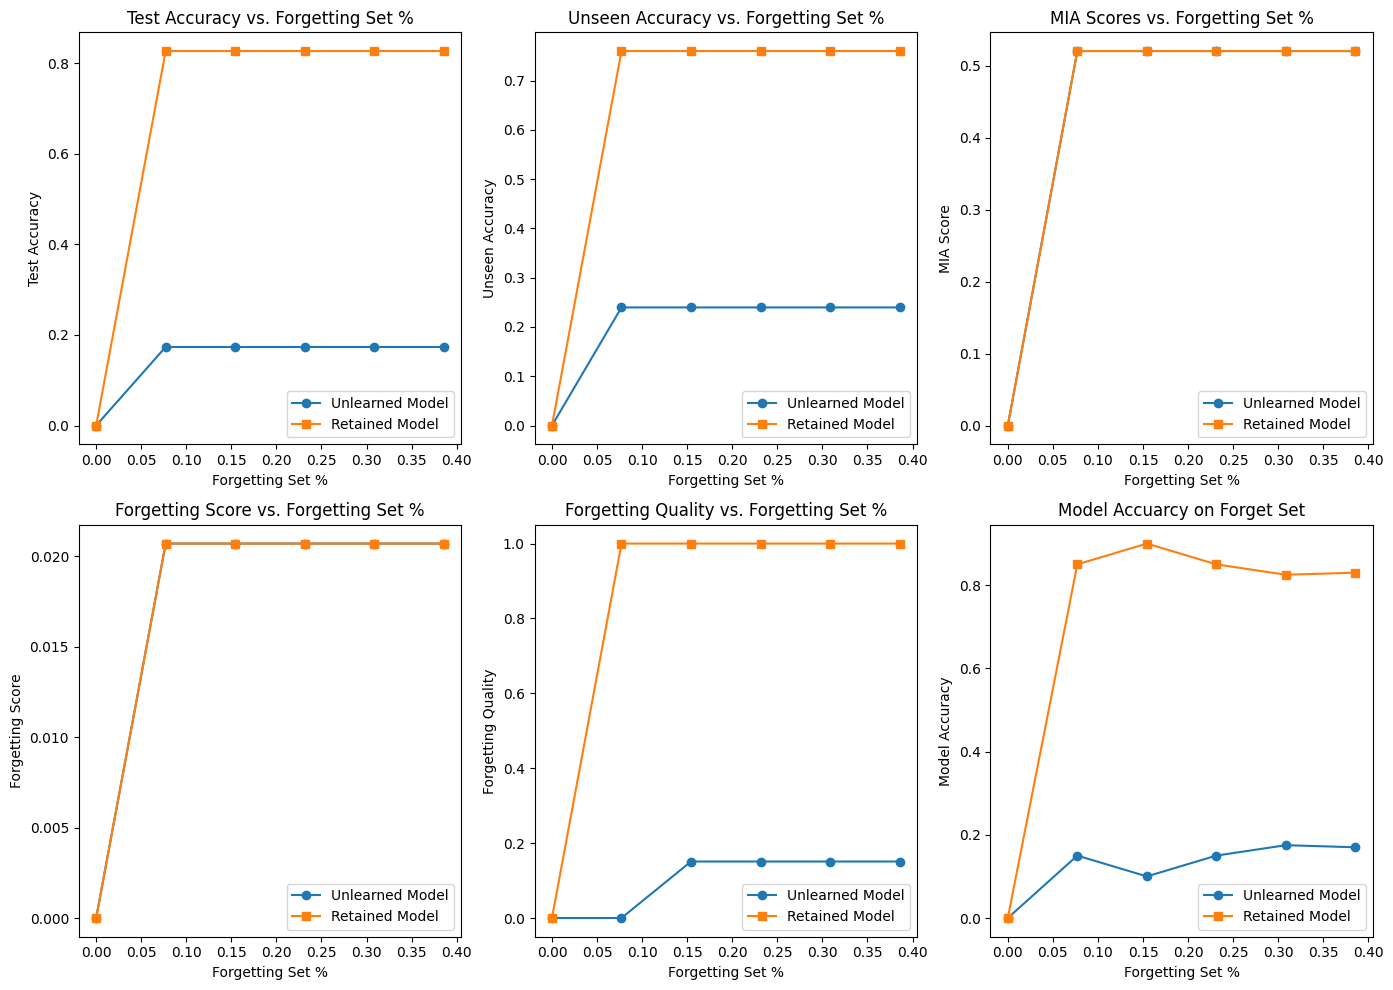

In [101]:
import matplotlib.pyplot as plt

# Experiment parameters
k_values = [0, 20, 40, 60, 80, 100]
forget_set_percentages = [k / len(train_set) * 100 for k in k_values]

# Initialize lists to store results
test_acc_unlearned_list = []
unseen_acc_unlearned_list = []
mia_unlearned_list = []
forgetting_score_unlearned_list = []
forgetting_quality_unlearned_list = []
WCFS_unlearned_list = []

test_acc_retrained_list = []
unseen_acc_retrained_list = []
mia_retrained_list = []
forgetting_score_retrained_list = []
forgetting_quality_retrained_list = []
WCFS_retrained_list = []

# Run experiments for each k value
for k in k_values:
    if k == 0:
        # Initialize metrics to default values for k=0
        WCFS_unlearned = 0
        test_acc_unlearned = 0
        unseen_acc_unlearned = 0
        mia_unlearned = 0
        forgetting_score_unlearned = 0
        forgetting_quality_unlearned = 0

        WCFS_retrained = 0
        test_acc_retrained = 0
        unseen_acc_retrained = 0
        mia_retrained = 0
        forgetting_score_retrained = 0
        forgetting_quality_retrained = 0
    else:
        worst_case_forget_set = [train_set[i] for i in worst_case_indices[:k]]
        worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)  # Create DataLoader for worst-case forget set

        # Evaluate the unlearned model
        WCFS_unlearned = evaluation(unlearned_model, worst_case_forget_loader)['Acc']
        test_acc_unlearned = evaluation(unlearned_model, test_dataloader)['Acc']
        unseen_acc_unlearned = evaluation(unlearned_model, unseen_dataloader)['Acc']
        mia_unlearned, forgetting_score_unlearned = get_mia_metrics(unlearned_model)
        
        # Handle potential division by zero
        if retain_acc_retrained == 0 or test_acc_retrained == 0:
            forgetting_quality_unlearned = 0  # or another default value
        else:
            forgetting_quality_unlearned = compute_forgetting_score(
                FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained
            )['Forgeting Quality']

        WCFS_retrained = evaluation(retrained_model, worst_case_forget_loader)['Acc']
        test_acc_retrained = evaluation(retrained_model, test_dataloader)['Acc']
        unseen_acc_retrained = evaluation(retrained_model, unseen_dataloader)['Acc']
        mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
        
        # Handle potential division by zero
        if retain_acc_retrained == 0 or test_acc_retrained == 0:
            forgetting_quality_retrained = 0  # or another default value
        else:
            forgetting_quality_retrained = compute_forgetting_score(
                FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained
            )['Forgeting Quality']

    # Append results
    WCFS_unlearned_list.append(WCFS_unlearned)
    test_acc_unlearned_list.append(test_acc_unlearned)
    unseen_acc_unlearned_list.append(unseen_acc_unlearned)
    mia_unlearned_list.append(mia_unlearned)
    forgetting_score_unlearned_list.append(forgetting_score_unlearned)
    forgetting_quality_unlearned_list.append(forgetting_quality_unlearned)

    WCFS_retrained_list.append(WCFS_retrained)
    test_acc_retrained_list.append(test_acc_retrained)
    unseen_acc_retrained_list.append(unseen_acc_retrained)
    mia_retrained_list.append(mia_retrained)
    forgetting_score_retrained_list.append(forgetting_score_retrained)
    forgetting_quality_retrained_list.append(forgetting_quality_retrained)

# Plotting results
plt.figure(figsize=(14, 10))

# Plotting Test Accuracy
plt.subplot(2, 3, 1)
plt.plot(forget_set_percentages, test_acc_unlearned_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, test_acc_retrained_list, marker='s', label='Retained Model')
plt.title('Test Accuracy vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Test Accuracy')
plt.legend()

# Plotting Unseen Accuracy
plt.subplot(2, 3, 2)
plt.plot(forget_set_percentages, unseen_acc_unlearned_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, unseen_acc_retrained_list, marker='s', label='Retained Model')
plt.title('Unseen Accuracy vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Unseen Accuracy')
plt.legend()

# Plotting MIA Scores
plt.subplot(2, 3, 3)
plt.plot(forget_set_percentages, mia_unlearned_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, mia_retrained_list, marker='s', label='Retained Model')
plt.title('MIA Scores vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('MIA Score')
plt.legend()

# Plotting Forgetting Score
plt.subplot(2, 3, 4)
plt.plot(forget_set_percentages, forgetting_score_unlearned_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, forgetting_score_retrained_list, marker='s', label='Retained Model')
plt.title('Forgetting Score vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Forgetting Score')
plt.legend()

# Plotting Forgetting Quality
plt.subplot(2, 3, 5)
plt.plot(forget_set_percentages, forgetting_quality_unlearned_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, forgetting_quality_retrained_list, marker='s', label='Retained Model')
plt.title('Forgetting Quality vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Forgetting Quality')
plt.legend()

# Plotting WCFS
plt.subplot(2, 3, 6)
plt.plot(forget_set_percentages, WCFS_unlearned_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, WCFS_retrained_list, marker='s', label='Retained Model')
plt.title('Model Accuarcy on Forget Set')
plt.xlabel('Forgetting Set %')
plt.ylabel('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
# Check if GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [44]:
set_seed(42)

# Define the Weight Filtering Layer
class WeightFilteringLayer(nn.Module):
    def __init__(self, in_features, num_classes):
        super(WeightFilteringLayer, self).__init__()
        self.memory_vectors = nn.Parameter(torch.ones(num_classes, in_features))

    def forward(self, x, y_unl):
        memory_vector = self.memory_vectors[y_unl]
        return x * memory_vector

# Modify the ResNet18 model to include the WF layer
class ResNet18WithWF(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResNet18WithWF, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.wf_layer = WeightFilteringLayer(original_model.fc.in_features, num_classes)
        self.fc = nn.Linear(original_model.fc.in_features, num_classes)

    def forward(self, x, y_unl=1):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.wf_layer(x, y_unl)
        x = self.fc(x)
        return x

# Load the pre-trained model and modify it
original_model = models.resnet18(pretrained=True)
unlearnedWF_model = ResNet18WithWF(original_model, num_classes=2)

# Load the state dictionary of the pre-trained model
pretrained_state_dict = torch.load('pre_trained_checkpoint_y.pth')

# Get the state dictionary of the modified model
unlearnedWF_model_state_dict = unlearnedWF_model.state_dict()

# Update the modified model state dictionary with the pre-trained model state dictionary
for name, param in pretrained_state_dict.items():
    if name in unlearnedWF_model_state_dict:
        unlearnedWF_model_state_dict[name] = param

# Load the updated state dictionary into the modified model
unlearnedWF_model.load_state_dict(unlearnedWF_model_state_dict)

# Move the model to GPU
unlearnedWF_model = unlearnedWF_model.cuda()

In [119]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedWF_model.parameters(), lr=0.001)

# Train the model with the weight filtering layer
num_epochs = 2
print_every = 20

# Start timing the unlearning process
start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.cuda()
        labels = labels.cuda()

        y_unl = 1  # Specify the class to be forgotten
        outputs = unlearnedWF_model(imgs, y_unl)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss.item():.4f}")

    average_epoch_loss = running_loss / len(retain_dataloader_train.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_epoch_loss:.4f}")

# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
print(f"Total unlearning time: {unlearning_time:.2f} seconds")

# Evaluate the unlearned model
test_acc = evaluation(unlearnedWF_model, test_dataloader)
unseen_acc = evaluation(unlearnedWF_model, unseen_dataloader)
mia = cal_mia(unlearnedWF_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Epoch [1/2], Batch [20/657] - Batch Loss: 0.4071
Epoch [1/2], Batch [40/657] - Batch Loss: 0.3733
Epoch [1/2], Batch [60/657] - Batch Loss: 0.2589
Epoch [1/2], Batch [80/657] - Batch Loss: 0.2498
Epoch [1/2], Batch [100/657] - Batch Loss: 0.2057
Epoch [1/2], Batch [120/657] - Batch Loss: 0.2123
Epoch [1/2], Batch [140/657] - Batch Loss: 0.3046
Epoch [1/2], Batch [160/657] - Batch Loss: 0.2661
Epoch [1/2], Batch [180/657] - Batch Loss: 0.3362
Epoch [1/2], Batch [200/657] - Batch Loss: 0.2362
Epoch [1/2], Batch [220/657] - Batch Loss: 0.4070
Epoch [1/2], Batch [240/657] - Batch Loss: 0.3164
Epoch [1/2], Batch [260/657] - Batch Loss: 0.1700
Epoch [1/2], Batch [280/657] - Batch Loss: 0.2825
Epoch [1/2], Batch [300/657] - Batch Loss: 0.4100
Epoch [1/2], Batch [320/657] - Batch Loss: 0.3328
Epoch [1/2], Batch [340/657] - Batch Loss: 0.3881
Epoch [1/2], Batch [360/657] - Batch Loss: 0.2389
Epoch [1/2], Batch [380/657] - Batch Loss: 0.2987
Epoch [1/2], Batch [400/657] - Batch Loss: 0.2097
Epoc

In [46]:
#evaluation metric for forget quality

In [47]:
# with DP metrics to the weight puning model
# Define the WeightFilteringLayer ******REPEAT WORK*********
set_seed(42)

# Define the Weight Filtering Layer
class WeightFilteringLayer(nn.Module):
    def __init__(self, in_features, num_classes):
        super(WeightFilteringLayer, self).__init__()
        self.memory_vectors = nn.Parameter(torch.ones(num_classes, in_features))

    def forward(self, x, y_unl):
        memory_vector = self.memory_vectors[y_unl]
        return x * memory_vector

# Modify the ResNet18 model to include the WF layer
class ResNet18WithWF(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResNet18WithWF, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.wf_layer = WeightFilteringLayer(original_model.fc.in_features, num_classes)
        self.fc = nn.Linear(original_model.fc.in_features, num_classes)

    def forward(self, x, y_unl=1):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.wf_layer(x, y_unl)
        x = self.fc(x)
        return x

# Load the pre-trained model and modify it
original_model = models.resnet18(pretrained=True)
unlearnedWF_model = ResNet18WithWF(original_model, num_classes=2)

# Load the state dictionary of the pre-trained model
pretrained_state_dict = torch.load('pre_trained_checkpoint_y.pth')

# Get the state dictionary of the modified model
unlearnedWF_model_state_dict = unlearnedWF_model.state_dict()

# Update the modified model state dictionary with the pre-trained model state dictionary
for name, param in pretrained_state_dict.items():
    if name in unlearnedWF_model_state_dict:
        unlearnedWF_model_state_dict[name] = param

# Load the updated state dictionary into the modified model
unlearnedWF_model.load_state_dict(unlearnedWF_model_state_dict)

# Move the model to GPU
unlearnedWF_model = unlearnedWF_model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedWF_model.parameters(), lr=0.001)

# Train the model with the weight filtering layer
num_epochs = 2
print_every = 20

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.cuda()
        labels = labels.cuda()

        y_unl = 1  # Specify the class to be forgotten
        outputs = unlearnedWF_model(imgs, y_unl)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss.item():.4f}")

    average_epoch_loss = running_loss / len(retain_dataloader_train.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_epoch_loss:.4f}")

# Evaluate the unlearned model
test_acc = evaluation(unlearnedWF_model, test_dataloader)
unseen_acc = evaluation(unlearnedWF_model, unseen_dataloader)
mia = cal_mia(unlearnedWF_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


Epoch [1/2], Batch [20/657] - Batch Loss: 0.5198
Epoch [1/2], Batch [40/657] - Batch Loss: 0.5716
Epoch [1/2], Batch [60/657] - Batch Loss: 0.5737
Epoch [1/2], Batch [80/657] - Batch Loss: 0.5119
Epoch [1/2], Batch [100/657] - Batch Loss: 0.3861
Epoch [1/2], Batch [120/657] - Batch Loss: 0.7123
Epoch [1/2], Batch [140/657] - Batch Loss: 0.7198
Epoch [1/2], Batch [160/657] - Batch Loss: 0.2345
Epoch [1/2], Batch [180/657] - Batch Loss: 0.2858
Epoch [1/2], Batch [200/657] - Batch Loss: 0.2920
Epoch [1/2], Batch [220/657] - Batch Loss: 0.3344
Epoch [1/2], Batch [240/657] - Batch Loss: 0.5290
Epoch [1/2], Batch [260/657] - Batch Loss: 0.3634
Epoch [1/2], Batch [280/657] - Batch Loss: 0.3990
Epoch [1/2], Batch [300/657] - Batch Loss: 0.3788
Epoch [1/2], Batch [320/657] - Batch Loss: 0.2234
Epoch [1/2], Batch [340/657] - Batch Loss: 0.2691
Epoch [1/2], Batch [360/657] - Batch Loss: 0.3058
Epoch [1/2], Batch [380/657] - Batch Loss: 0.2912
Epoch [1/2], Batch [400/657] - Batch Loss: 0.2794
Epoc

In [48]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

# Calculate FPR and FNR
def calculate_fpr_fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    return fpr, fnr

# Calculate per-example epsilon
def calculate_per_example_epsilon(FPR_list, FNR_list, delta=1e-5):
    per_example_epsilons = []
    
    for FPR, FNR in zip(FPR_list, FNR_list):
        if FPR == 0 and FNR == 0:
            per_example_epsilons.append(np.inf)
        elif FPR == 0 or FNR == 0:
            continue  # Discard attack if exactly one of FPR or FNR is 0
        else:
            epsilon1 = np.log(1 - delta - FPR) - np.log(FNR)
            epsilon2 = np.log(1 - delta - FNR) - np.log(FPR)
            per_example_epsilons.append(np.nanmax([epsilon1, epsilon2]))
    
    epsilon = np.nanmax(per_example_epsilons) if per_example_epsilons else 0
    return epsilon

def calculate_H(epsilon, bin_width=0.5, max_epsilon=6.5):
    bin_index = min(int(epsilon / bin_width), int(max_epsilon / bin_width))
    H_value = 2 / (2 ** bin_index)
    return H_value

def calculate_F(H_values):
    return np.mean(H_values)

def calculate_final_score(F_value, RA_U, RA_R, TA_U, TA_R):
    return F_value * (RA_U / RA_R) * (TA_U / TA_R)

def compute_forgetting_score(FPR_list, FNR_list, RA_U, RA_R, TA_U, TA_R, delta=1e-5, bin_width=0.5, max_epsilon=6.5):
    epsilon_values = [calculate_per_example_epsilon(FPR_list, FNR_list, delta)]
    H_values = [calculate_H(epsilon, bin_width, max_epsilon) for epsilon in epsilon_values]
    F_value = calculate_F(H_values)
    final_score = calculate_final_score(F_value, RA_U, RA_R, TA_U, TA_R)

    result = {
        'Epsilon Values': epsilon_values,
        'H Values': H_values,
        'F Value': F_value,
        'RA^U': RA_U,
        'RA^R': RA_R,
        'TA^U': TA_U,
        'TA^R': TA_R,
        'Forgeting Quality': final_score
    }
    
    # Print each key-value pair on a separate line
    for key, value in result.items():
        print(f"{key}: {value}")
    
    return result

# Function to calculate accuracy using your existing evaluation method
def calculate_accuracy(model, dataloader):
    evaluation_result = evaluation(model, dataloader)
    return evaluation_result['Acc']

#Function to get MIA metrics using your existing cal_mia method
def get_mia_metrics(model):
    mia = cal_mia(model)
    return mia['MIA'], mia['Forgeting Score']

# Function to get predictions and true labels
@torch.no_grad()
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.cuda()
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)



In [49]:
# Evaluate the unlearned model
test_acc_unlearned = calculate_accuracy(unlearnedWF_model, test_dataloader)
retain_acc_unlearned = calculate_accuracy(unlearnedWF_model, retain_dataloader_train)
unseen_acc_unlearned = calculate_accuracy(unlearnedWF_model, unseen_dataloader)
mia_unlearned, forgetting_score_unlearned = get_mia_metrics(unlearnedWF_model)

print(f'Test Acc (Unlearned): {test_acc_unlearned}')
print(f'Retain Acc (Unlearned): {retain_acc_unlearned}')
print(f'Unseen Acc (Unlearned): {unseen_acc_unlearned}')
print(f'MIA (Unlearned): {mia_unlearned}')
print(f'Final Score (Unlearned): {(test_acc_unlearned + (1 - abs(mia_unlearned - 0.5) * 2)) / 2}')

# Evaluate the retain model
test_acc_retrained = calculate_accuracy(retrained_model, test_dataloader)
retain_acc_retrained = calculate_accuracy(retrained_model, retain_dataloader_train)
unseen_acc_retrained = calculate_accuracy(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)

print(f'Test Acc (Retained): {test_acc_retrained}')
print(f'Retain Acc (Retained): {retain_acc_retrained}')
print(f'Unseen Acc (Retained): {unseen_acc_retrained}')
print(f'MIA (Retained): {mia_retrained}')
print(f'Final Score (Retained): {(test_acc_retrained + (1 - abs(mia_retrained - 0.5) * 2)) / 2}')



# Calculate DP metrics for unlearned model
preds_unlearned, labels_unlearned = get_predictions(unlearnedWF_model, test_dataloader)
fpr_unlearned, fnr_unlearned = calculate_fpr_fnr(labels_unlearned, preds_unlearned)
FPR_list_unlearned = [fpr_unlearned]
FNR_list_unlearned = [fnr_unlearned]

# Compute forgetting score for unlearned model
results_unlearned = compute_forgetting_score(FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained)
print("Forgetting Quality (Unlearned):", results_unlearned)

# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]

# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)
print("Forgetting Score (Retained):", results_retrained)

Test Acc (Unlearned): 0.8832929782082325
Retain Acc (Unlearned): 0.857904761904762
Unseen Acc (Unlearned): 0.8461538461538461
MIA (Unlearned): 0.5077306733167083
Final Score (Unlearned): 0.9339158157874079
Test Acc (Retained): 0.7317191283292979
Retain Acc (Retained): 0.6881904761904762
Unseen Acc (Retained): 0.6193806193806194
MIA (Retained): 0.5361596009975063
Final Score (Retained): 0.8296999631671427
Epsilon Values: [3.206464278679144]
H Values: [0.03125]
F Value: 0.03125
RA^U: 0.857904761904762
RA^R: 0.6881904761904762
TA^U: 0.8832929782082325
TA^R: 0.7317191283292979
Forgeting Quality: 0.04702630016652492
Forgetting Quality (Unlearned): {'Epsilon Values': [3.206464278679144], 'H Values': [0.03125], 'F Value': 0.03125, 'RA^U': 0.857904761904762, 'RA^R': 0.6881904761904762, 'TA^U': 0.8832929782082325, 'TA^R': 0.7317191283292979, 'Forgeting Quality': 0.04702630016652492}
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.68819047619047

In [50]:
# Calculate DP metrics for unlearned model
preds_unlearned, labels_unlearned = get_predictions(unlearnedWF_model, test_dataloader)
fpr_unlearned, fnr_unlearned = calculate_fpr_fnr(labels_unlearned, preds_unlearned)
FPR_list_unlearned = [fpr_unlearned]
FNR_list_unlearned = [fnr_unlearned]

# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]

# Compute forgetting score for unlearned model
results_unlearned = compute_forgetting_score(FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained)
print("Forgetting Quality (Unlearned):", results_unlearned)
print()
print()

# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)
print("Forgetting Quality (Retained):", results_retrained)

Epsilon Values: [3.206464278679144]
H Values: [0.03125]
F Value: 0.03125
RA^U: 0.857904761904762
RA^R: 0.6881904761904762
TA^U: 0.8832929782082325
TA^R: 0.7317191283292979
Forgeting Quality: 0.04702630016652492
Forgetting Quality (Unlearned): {'Epsilon Values': [3.206464278679144], 'H Values': [0.03125], 'F Value': 0.03125, 'RA^U': 0.857904761904762, 'RA^R': 0.6881904761904762, 'TA^U': 0.8832929782082325, 'TA^R': 0.7317191283292979, 'Forgeting Quality': 0.04702630016652492}


Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.7317191283292979
TA^R: 0.7317191283292979
Forgeting Quality: 1.0
Forgetting Quality (Retained): {'Epsilon Values': [0.9723385625358509], 'H Values': [1.0], 'F Value': 1.0, 'RA^U': 0.6881904761904762, 'RA^R': 0.6881904761904762, 'TA^U': 0.7317191283292979, 'TA^R': 0.7317191283292979, 'Forgeting Quality': 1.0}


In [51]:
# Define the JS Divergence calculation function
def JSDiv(p, q):
    m = (p + q) / 2
    return 0.5 * F.kl_div(torch.log(p), m, reduction='batchmean') + 0.5 * F.kl_div(torch.log(q), m, reduction='batchmean')
    #This provides a normalized score, which is often useful for comparing different batches or datasets. 
    #If you prefer to sum over the batch instead, you can change this to reduction='sum'

# Define the unlearning score calculation function
def ZRFScore(tmodel, gold_model, forget_dl, device):
    model_preds = []
    gold_model_preds = []
    with torch.no_grad():
        for batch in forget_dl:
            x, _ = batch
            x = x.to(device)
            model_output = tmodel(x)
            gold_model_output = gold_model(x)
            model_preds.append(F.softmax(model_output, dim=1).detach().cpu())
            gold_model_preds.append(F.softmax(gold_model_output, dim=1).detach().cpu())
    
    model_preds = torch.cat(model_preds, axis=0)
    gold_model_preds = torch.cat(gold_model_preds, axis=0)
    return 1 - JSDiv(model_preds, gold_model_preds)

# Compute ZRF and JS divergence scores
def compute_ZRF_JS_score(unlearned_model, original_model, forget_dataloader, device):
    # Compute JS Divergence
    js_div_score = 1 - ZRFScore(original_model, unlearned_model, forget_dataloader, device)
    #The 1 - UnLearningScore construct is used to convert the unlearning score 
    #(which is based on JS divergence) into a more intuitive measure where a 
    #higher score indicates better unlearning.
    
    # Compute ZRF Score using JS divergence
    zrf_score = ZRFScore(original_model, unlearned_model, forget_dataloader, device)
    
    return {'JS_Divergence': js_div_score.item(), 'ZRF_Score': zrf_score.item()}

In [52]:
# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the models are on the correct device
unlearnedWF_model = unlearnedWF_model.to(device)
model = model.to(device)

results = compute_ZRF_JS_score(unlearnedWF_model, model, forget_dataloader_test, device)
print(results)

{'JS_Divergence': 0.05387204885482788, 'ZRF_Score': 0.9461279511451721}


In [53]:
# Create DataLoader for worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)

# Evaluate your unlearning model on the worst-case forget set
evaluation_results = evaluation(unlearnedWF_model, worst_case_forget_loader)
print("Evaluation on worst-case forget set:", evaluation_results)


Evaluation on worst-case forget set: {'Loss': 0.218, 'Acc': 0.9}


Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.7317191283292979
TA^R: 0.7317191283292979
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.24755555555555556
RA^R: 0.6881904761904762
TA^U: 0.17336561743341405
TA^R: 0.7317191283292979
Forgeting Quality: 0.17045611146698056
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.7317191283292979
TA^R: 0.7317191283292979
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.24755555555555556
RA^R: 0.6881904761904762
TA^U: 0.17336561743341405
TA^R: 0.7317191283292979
Forgeting Quality: 0.17045611146698056
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.7317191283292979
TA^R: 0.7317191283292979
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U

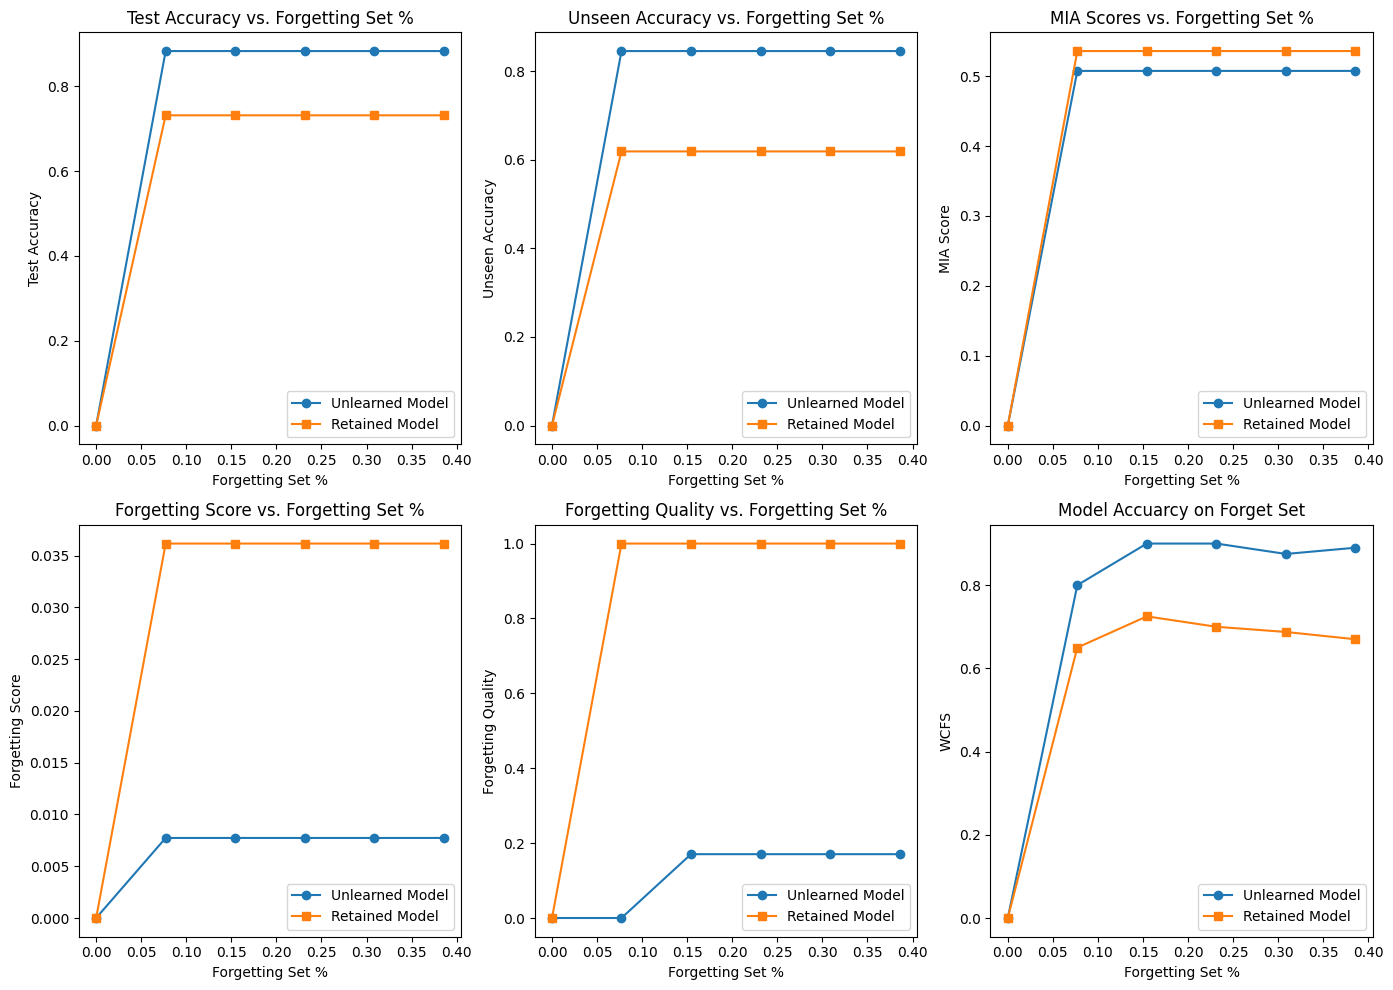

In [88]:
import matplotlib.pyplot as plt

# Experiment parameters
k_values = [0, 20, 40, 60, 80, 100]
forget_set_percentages = [k / len(train_set) * 100 for k in k_values]

# Initialize lists to store results
test_acc_unlearnedWF_list = []
unseen_acc_unlearnedWF_list = []
mia_unlearnedWF_list = []
forgetting_score_unlearnedWF_list = []
forgetting_quality_unlearnedWF_list = []
WCFS_unlearnedWF_list = []

test_acc_retrained_list = []
unseen_acc_retrained_list = []
mia_retrained_list = []
forgetting_score_retrained_list = []
forgetting_quality_retrained_list = []
WCFS_retrained_list = []

# Run experiments for each k value
for k in k_values:
    if k == 0:
        # Initialize metrics to default values for k=0
        WCFS_unlearnedWF = 0
        test_acc_unlearnedWF = 0
        unseen_acc_unlearnedWF = 0
        mia_unlearnedWF = 0
        forgetting_score_unlearnedWF = 0
        forgetting_quality_unlearnedWF = 0

        WCFS_retrained = 0
        test_acc_retrained = 0
        unseen_acc_retrained = 0
        mia_retrained = 0
        forgetting_score_retrained = 0
        forgetting_quality_retrained = 0
    else:
        worst_case_forget_set = [train_set[i] for i in worst_case_indices[:k]]
        worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)  # Create DataLoader for worst-case forget set

        # Evaluate the unlearned model
        WCFS_unlearnedWF = evaluation(unlearnedWF_model, worst_case_forget_loader)['Acc']
        test_acc_unlearnedWF = evaluation(unlearnedWF_model, test_dataloader)['Acc']
        unseen_acc_unlearnedWF = evaluation(unlearnedWF_model, unseen_dataloader)['Acc']
        mia_unlearnedWF, forgetting_score_unlearnedWF = get_mia_metrics(unlearnedWF_model)
        
        # Handle potential division by zero
        if retain_acc_retrained == 0 or test_acc_retrained == 0:
            forgetting_quality_unlearnedWF = 0  # or another default value
        else:
            forgetting_quality_unlearnedWF = compute_forgetting_score(
                FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained
            )['Forgeting Quality']

        WCFS_retrained = evaluation(retrained_model, worst_case_forget_loader)['Acc']
        test_acc_retrained = evaluation(retrained_model, test_dataloader)['Acc']
        unseen_acc_retrained = evaluation(retrained_model, unseen_dataloader)['Acc']
        mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
        
        # Handle potential division by zero
        if retain_acc_retrained == 0 or test_acc_retrained == 0:
            forgetting_quality_retrained = 0  # or another default value
        else:
            forgetting_quality_retrained = compute_forgetting_score(
                FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained
            )['Forgeting Quality']

    # Append results
    WCFS_unlearnedWF_list.append(WCFS_unlearnedWF)
    test_acc_unlearnedWF_list.append(test_acc_unlearnedWF)
    unseen_acc_unlearnedWF_list.append(unseen_acc_unlearnedWF)
    mia_unlearnedWF_list.append(mia_unlearnedWF)
    forgetting_score_unlearnedWF_list.append(forgetting_score_unlearnedWF)
    forgetting_quality_unlearnedWF_list.append(forgetting_quality_unlearnedWF)

    WCFS_retrained_list.append(WCFS_retrained)
    test_acc_retrained_list.append(test_acc_retrained)
    unseen_acc_retrained_list.append(unseen_acc_retrained)
    mia_retrained_list.append(mia_retrained)
    forgetting_score_retrained_list.append(forgetting_score_retrained)
    forgetting_quality_retrained_list.append(forgetting_quality_retrained)

# Plotting results
plt.figure(figsize=(14, 10))

# Plotting Test Accuracy
plt.subplot(2, 3, 1)
plt.plot(forget_set_percentages, test_acc_unlearnedWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, test_acc_retrained_list, marker='s', label='Retained Model')
plt.title('Test Accuracy vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Test Accuracy')
plt.legend()

# Plotting Unseen Accuracy
plt.subplot(2, 3, 2)
plt.plot(forget_set_percentages, unseen_acc_unlearnedWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, unseen_acc_retrained_list, marker='s', label='Retained Model')
plt.title('Unseen Accuracy vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Unseen Accuracy')
plt.legend()

# Plotting MIA Scores
plt.subplot(2, 3, 3)
plt.plot(forget_set_percentages, mia_unlearnedWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, mia_retrained_list, marker='s', label='Retained Model')
plt.title('MIA Scores vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('MIA Score')
plt.legend()

# Plotting Forgetting Score
plt.subplot(2, 3, 4)
plt.plot(forget_set_percentages, forgetting_score_unlearnedWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, forgetting_score_retrained_list, marker='s', label='Retained Model')
plt.title('Forgetting Score vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Forgetting Score')
plt.legend()

# Plotting Forgetting Quality
plt.subplot(2, 3, 5)
plt.plot(forget_set_percentages, forgetting_quality_unlearnedWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, forgetting_quality_retrained_list, marker='s', label='Retained Model')
plt.title('Forgetting Quality vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Forgetting Quality')
plt.legend()

# Plotting WCFS
plt.subplot(2, 3, 6)
plt.plot(forget_set_percentages, WCFS_unlearnedWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, WCFS_retrained_list, marker='s', label='Retained Model')
plt.title('Model Accuarcy on Forget Set')
plt.xlabel('Forgetting Set %')
plt.ylabel('WCFS')
plt.legend()

plt.tight_layout()
plt.show()


In [120]:
#Relearn time function
reqAcc = 88
lr = 0.001  
original_model.to(device)
rltime = relearn_time(unlearnedWF_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
print(f'Relearn time: {rltime} epochs')
# # Calculating JS divergence and ZRF score
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# JSZRF = compute_ZRF_JS_score(retrained_model, model, forget_dataloader_test, device)
# print(JSZRF)
# Get predictions and true labels
y_true, y_pred = get_predictions(unlearnedWF_model, test_dataloader)
# Calculate HTER
hter = calculate_hter(y_true, y_pred)
print(f'HTER: {hter}')

Relearn time: 3 epochs
HTER: 0.14404720381351005


In [54]:
# Define the updated weight filtering layer
class EnhancedWeightFilteringLayer(nn.Module):
    def __init__(self, original_model, num_classes):
        super(EnhancedWeightFilteringLayer, self).__init__()
        self.original_model = original_model
        self.num_classes = num_classes

    def forward(self, x, y_unl):
        # Apply weight filtering
        logits = self.original_model(x)
        for param in self.original_model.parameters():
            param.data *= (torch.abs(param.data) > 0.01).float()  # Adjust threshold as needed
        return logits

# Define the updated model with the enhanced weight filtering layer
class ResNet18WithEnhancedWF(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResNet18WithEnhancedWF, self).__init__()
        self.weight_filtering_layer = EnhancedWeightFilteringLayer(original_model, num_classes)

    def forward(self, x, y_unl=None):
        return self.weight_filtering_layer(x, y_unl)

# Load the pre-trained model and modify it
original_model = models.resnet18(pretrained=True)
unlearnedEWF_model = ResNet18WithEnhancedWF(original_model, num_classes=2)

# Load the state dictionary of the pre-trained model
pretrained_state_dict = torch.load('pre_trained_checkpoint_y.pth')

# Update the modified model state dictionary with the pre-trained model state dictionary
unlearnedEWF_model_state_dict = unlearnedEWF_model.state_dict()
for name, param in pretrained_state_dict.items():
    if name in unlearnedEWF_model_state_dict:
        unlearnedEWF_model_state_dict[name] = param

# Load the updated state dictionary into the modified model
unlearnedEWF_model.load_state_dict(unlearnedEWF_model_state_dict)

# Move the model to GPU
unlearnedEWF_model = unlearnedEWF_model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

# Train the model with the enhanced weight filtering layer
num_epochs = 2
print_every = 20

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.cuda()
        labels = labels.cuda()

        y_unl = 1  # Specify the class to be forgotten
        outputs = unlearnedEWF_model(imgs, y_unl)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss.item():.4f}")

    average_epoch_loss = running_loss / len(retain_dataloader_train.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_epoch_loss:.4f}")


Epoch [1/2], Batch [20/657] - Batch Loss: 11.0662
Epoch [1/2], Batch [40/657] - Batch Loss: 10.7713
Epoch [1/2], Batch [60/657] - Batch Loss: 11.4922
Epoch [1/2], Batch [80/657] - Batch Loss: 11.1570
Epoch [1/2], Batch [100/657] - Batch Loss: 11.2859
Epoch [1/2], Batch [120/657] - Batch Loss: 11.3432
Epoch [1/2], Batch [140/657] - Batch Loss: 10.9656
Epoch [1/2], Batch [160/657] - Batch Loss: 10.7133
Epoch [1/2], Batch [180/657] - Batch Loss: 11.1056
Epoch [1/2], Batch [200/657] - Batch Loss: 10.7155
Epoch [1/2], Batch [220/657] - Batch Loss: 11.2346
Epoch [1/2], Batch [240/657] - Batch Loss: 10.4350
Epoch [1/2], Batch [260/657] - Batch Loss: 10.7149
Epoch [1/2], Batch [280/657] - Batch Loss: 11.0177
Epoch [1/2], Batch [300/657] - Batch Loss: 10.4442
Epoch [1/2], Batch [320/657] - Batch Loss: 11.2742
Epoch [1/2], Batch [340/657] - Batch Loss: 11.0666
Epoch [1/2], Batch [360/657] - Batch Loss: 11.2389
Epoch [1/2], Batch [380/657] - Batch Loss: 10.7284
Epoch [1/2], Batch [400/657] - Batc

In [59]:
# Evaluate the unlearned model
test_acc = evaluation(unlearnedEWF_model, test_dataloader)
unseen_acc = evaluation(unlearnedEWF_model, unseen_dataloader)
mia = cal_mia(unlearnedEWF_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

# Evaluate your unlearning model on the worst-case forget set
evaluation_results_EWF = evaluation(unlearnedEWF_model, worst_case_forget_loader)
print("Evaluation on worst-case forget set:", evaluation_results_EWF)

Test Acc: {'Loss': 12.168, 'Acc': 0.0014527845036319612}
Unseen Acc: {'Loss': 11.952, 'Acc': 0.000999000999000999}
MIA: {'MIA': 0.5032418952618454, 'Forgeting Score': 0.0032418952618453734}
Final Score: 0.4974844969899706
Evaluation on worst-case forget set: {'Loss': 11.339, 'Acc': 0.0}


In [121]:
# 4) Threshold and Regularization Adjustments: Experiment with different threshold values and regularization coefficients to find a balance that maintains high loss on the forget set while improving general performance.
# 5) Fine-Tuning with a Smaller Learning Rate:: Fine-tuning with a smaller learning rate can help the model recover performance without drastically altering weights, maintaining the forgetfulness for the targeted class.
# 6) Apply Gradient Clipping: Gradient clipping can help stabilize training by preventing the gradients from becoming too large, which can improve overall performance.
# 7) Increased Fine-Tuning Epochs: Increasing the number of fine-tuning epochs can help the model converge better on the retained data.

set_seed(42)

# Define the enhanced weight filtering layer
class EnhancedWeightFilteringLayer(nn.Module):
    def __init__(self, threshold=0.01, l1_lambda=0.01, l2_lambda=0.01):
        super(EnhancedWeightFilteringLayer, self).__init__()
        self.threshold = threshold
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def forward(self, x):
        # Apply weight filtering to the input tensor
        x *= (torch.abs(x) > self.threshold).float()
        # Apply L1 and L2 regularization
        x -= self.l1_lambda * torch.sign(x)
        x -= self.l2_lambda * x
        return x

# Define the updated model with the enhanced weight filtering layer
class ResNet18WithEnhancedWF(nn.Module):
    def __init__(self, original_model, num_classes, threshold=0.01, l1_lambda=0.01, l2_lambda=0.01):
        super(ResNet18WithEnhancedWF, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.weight_filtering_layer = EnhancedWeightFilteringLayer(threshold, l1_lambda, l2_lambda)
        self.fc = nn.Linear(original_model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.weight_filtering_layer(x)
        x = self.fc(x)
        return x

# Load the pre-trained model and modify it
original_model = models.resnet18(pretrained=True)
unlearnedEWF_model = ResNet18WithEnhancedWF(original_model, num_classes=2)

# Load the state dictionary of the pre-trained model
pretrained_state_dict = torch.load('pre_trained_checkpoint_y.pth')

# Update the modified model state dictionary with the pre-trained model state dictionary
unlearnedEWF_model_state_dict = unlearnedEWF_model.state_dict()
for name, param in pretrained_state_dict.items():
    if name in unlearnedEWF_model_state_dict:
        unlearnedEWF_model_state_dict[name] = param

# Load the updated state dictionary into the modified model
unlearnedEWF_model.load_state_dict(unlearnedEWF_model_state_dict)

# Move the model to GPU
unlearnedEWF_model = unlearnedEWF_model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedEWF_model.parameters(), lr=0.001)

# Train the model with the enhanced weight filtering layer
num_epochs = 2
print_every = 20

# Start timing the unlearning process
start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.cuda()
        labels = labels.cuda()

        outputs = unlearnedEWF_model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss.item():.4f}")

    average_epoch_loss = running_loss / len(retain_dataloader_train.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_epoch_loss:.4f}")

# Fine-tune the unlearned model on the retain dataset with smaller learning rate and learning rate scheduling
fine_tune_optimizer = optim.SGD(unlearnedEWF_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(fine_tune_optimizer, step_size=5, gamma=0.1)

for epoch in range(num_epochs + 3):  # Increase fine-tuning epochs
    running_loss = 0

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.cuda()
        labels = labels.cuda()

        outputs = unlearnedEWF_model(imgs)
        loss = criterion(outputs, labels)

        fine_tune_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unlearnedEWF_model.parameters(), max_norm=1.0)  # Gradient clipping
        fine_tune_optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss.item():.4f}")

    average_epoch_loss = running_loss / len(retain_dataloader_train.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_epoch_loss:.4f}")
    scheduler.step()
# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time


# Evaluate the unlearned model
test_acc = evaluation(unlearnedEWF_model, test_dataloader)
unseen_acc = evaluation(unlearnedEWF_model, unseen_dataloader)
mia = cal_mia(unlearnedEWF_model.cuda())
#Relearn time function
reqAcc = 89
lr = 0.001  
unlearnedEWF_model.to(device)
rltime = relearn_time(unlearnedEWF_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
# Evaluate the unlearned model
test_acc_unlearnedEWF = calculate_accuracy(unlearnedEWF_model, test_dataloader)
retain_acc_unlearnedEWF = calculate_accuracy(unlearnedEWF_model, retain_dataloader_train)
unseen_acc_unlearnedEWF = calculate_accuracy(unlearnedEWF_model, unseen_dataloader)
mia_unlearnedEWF, forgetting_score_unlearnedEWF = get_mia_metrics(unlearnedEWF_model)
# Evaluate the retain model
test_acc_retrained = calculate_accuracy(retrained_model, test_dataloader)
retain_acc_retrained = calculate_accuracy(retrained_model, retain_dataloader_train)
unseen_acc_retrained = calculate_accuracy(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearnedEWF, labels_unlearnedEWF = get_predictions(unlearnedEWF_model, test_dataloader)
fpr_unlearnedEWF, fnr_unlearnedEWF = calculate_fpr_fnr(labels_unlearnedEWF, preds_unlearnedEWF)
FPR_list_unlearnedEWF = [fpr_unlearnedEWF]
FNR_list_unlearnedEWF = [fnr_unlearnedEWF]
# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]
# Compute forgetting score for unlearned model
results_unlearnedEWF = compute_forgetting_score(FPR_list_unlearnedEWF, FNR_list_unlearnedEWF, retain_acc_unlearnedEWF, retain_acc_retrained, test_acc_unlearnedEWF, test_acc_retrained)
# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
unlearnedEWF_model = unlearnedEWF_model.to(device)
js_divergence = compute_ZRF_JS_score(unlearnedEWF_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(unlearnedEWF_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearnedEWF_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)
# Evaluate your unlearning model on the worst-case forget set
evaluation_results_EWF = evaluation(unlearnedEWF_model, worst_case_forget_loader)



print(f'Test Acc (Unlearned): {test_acc_unlearnedEWF}')
print(f'Retain Acc (Unlearned): {retain_acc_unlearnedEWF}')
print(f'Unseen Acc (Unlearned): {unseen_acc_unlearnedEWF}')
print(f'MIA (Unlearned): {mia_unlearnedEWF}')
print(f'Final Score (Unlearned): {(test_acc_unlearnedEWF + (1 - abs(mia_unlearnedEWF - 0.5) * 2)) / 2}')
print(f'Test Acc (Retained): {test_acc_retrained}')
print(f'Retain Acc (Retained): {retain_acc_retrained}')
print(f'Unseen Acc (Retained): {unseen_acc_retrained}')
print(f'MIA (Retained): {mia_retrained}')
print(f'Final Score (Retained): {(test_acc_retrained + (1 - abs(mia_retrained - 0.5) * 2)) / 2}')
print('****************************************************')
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f"Total unlearning time: {unlearning_time:.2f} seconds")
print(f'Relearn time: {rltime} epochs')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')
print("Forgetting Quality (Unlearned):", results_unlearnedEWF)
print("Forgetting Score (Retained):", results_retrained)
print(f'JS Divergence: {js_divergence}')
print(f'ZRF Score: {zrf_score}')
print(f'HTER: {hter}')
print("Evaluation on worst-case forget set:", evaluation_results_EWF)

Epoch [1/2], Batch [20/657] - Batch Loss: 0.6774
Epoch [1/2], Batch [40/657] - Batch Loss: 0.8630
Epoch [1/2], Batch [60/657] - Batch Loss: 0.8865
Epoch [1/2], Batch [80/657] - Batch Loss: 0.8516
Epoch [1/2], Batch [100/657] - Batch Loss: 0.6027
Epoch [1/2], Batch [120/657] - Batch Loss: 0.6716
Epoch [1/2], Batch [140/657] - Batch Loss: 0.5363
Epoch [1/2], Batch [160/657] - Batch Loss: 0.3164
Epoch [1/2], Batch [180/657] - Batch Loss: 0.2554
Epoch [1/2], Batch [200/657] - Batch Loss: 0.4441
Epoch [1/2], Batch [220/657] - Batch Loss: 0.2991
Epoch [1/2], Batch [240/657] - Batch Loss: 0.8595
Epoch [1/2], Batch [260/657] - Batch Loss: 0.3710
Epoch [1/2], Batch [280/657] - Batch Loss: 0.4451
Epoch [1/2], Batch [300/657] - Batch Loss: 0.5106
Epoch [1/2], Batch [320/657] - Batch Loss: 0.2364
Epoch [1/2], Batch [340/657] - Batch Loss: 0.2917
Epoch [1/2], Batch [360/657] - Batch Loss: 0.3966
Epoch [1/2], Batch [380/657] - Batch Loss: 0.3252
Epoch [1/2], Batch [400/657] - Batch Loss: 0.3921
Epoc

Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.7317191283292979
TA^R: 0.7317191283292979
Forgeting Quality: 1.0
Epsilon Values: [4.475834239377023]
H Values: [0.0078125]
F Value: 0.0078125
RA^U: 0.8640634920634921
RA^R: 0.6881904761904762
TA^U: 0.8857142857142857
TA^R: 0.7317191283292979
Forgeting Quality: 0.011873431997958935
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.7317191283292979
TA^R: 0.7317191283292979
Forgeting Quality: 1.0
Epsilon Values: [4.475834239377023]
H Values: [0.0078125]
F Value: 0.0078125
RA^U: 0.8640634920634921
RA^R: 0.6881904761904762
TA^U: 0.8857142857142857
TA^R: 0.7317191283292979
Forgeting Quality: 0.011873431997958935
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.6881904761904762
RA^R: 0.6881904761904762
TA^U: 0.7317191283292979
TA^R: 0.7317191283292979
Forgeting Quality: 1.0

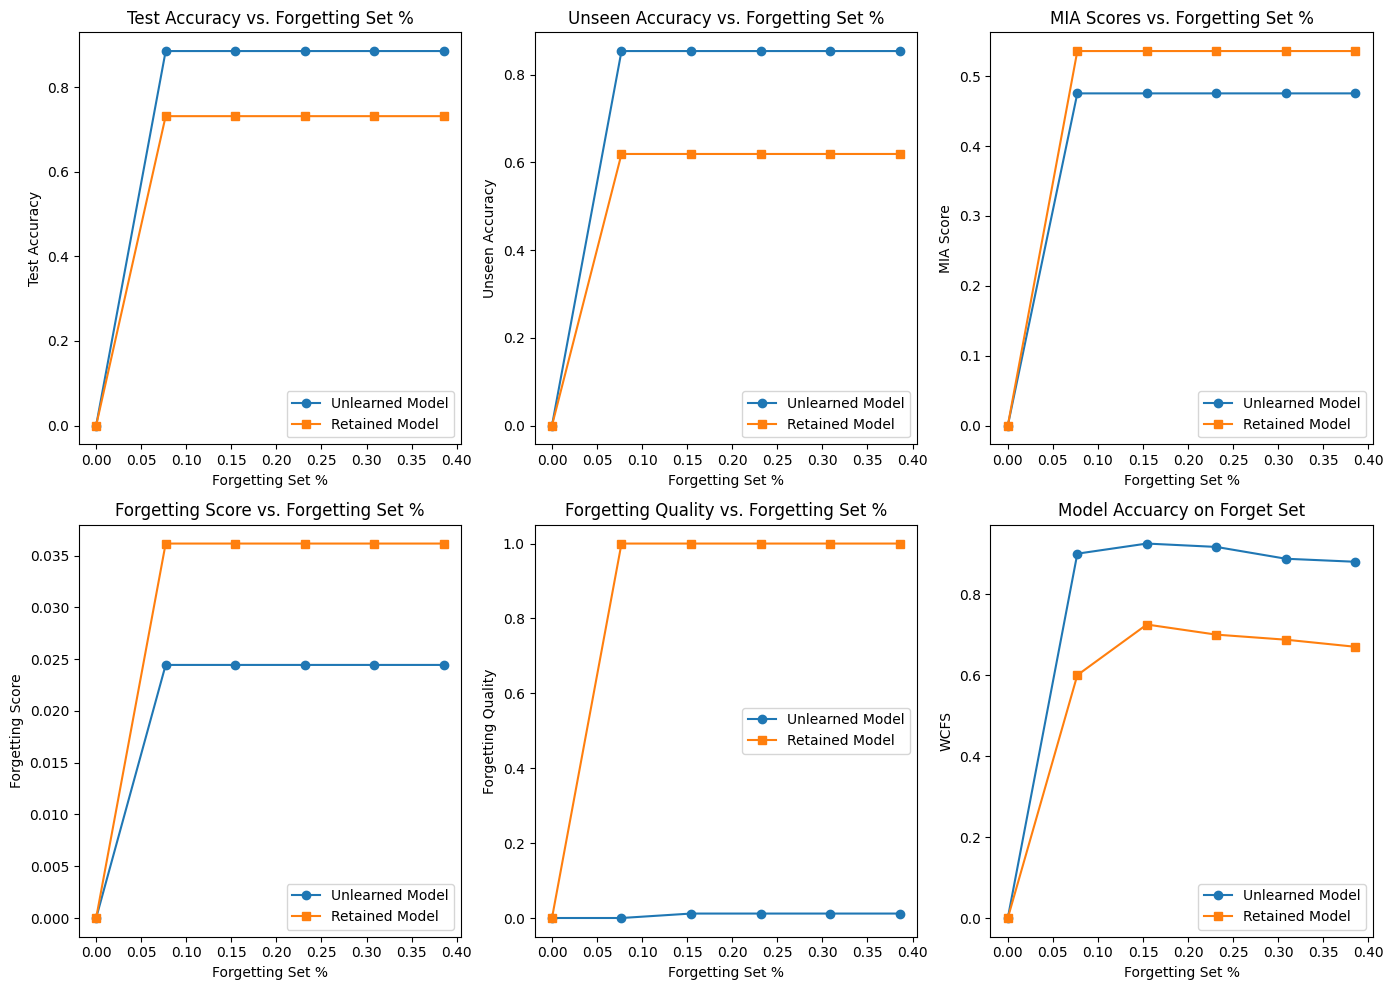

In [87]:
import matplotlib.pyplot as plt

# Experiment parameters
k_values = [0, 20, 40, 60, 80, 100]
forget_set_percentages = [k / len(train_set) * 100 for k in k_values]

# Initialize lists to store results
test_acc_unlearnedEWF_list = []
unseen_acc_unlearnedEWF_list = []
mia_unlearnedEWF_list = []
forgetting_score_unlearnedEWF_list = []
forgetting_quality_unlearnedEWF_list = []
WCFS_unlearnedEWF_list = []

test_acc_retrained_list = []
unseen_acc_retrained_list = []
mia_retrained_list = []
forgetting_score_retrained_list = []
forgetting_quality_retrained_list = []
WCFS_retrained_list = []

# Run experiments for each k value
for k in k_values:
    if k == 0:
        # Initialize metrics to default values for k=0
        WCFS_unlearnedEWF = 0
        test_acc_unlearnedEWF = 0
        unseen_acc_unlearnedEWF = 0
        mia_unlearnedEWF = 0
        forgetting_score_unlearnedEWF = 0
        forgetting_quality_unlearnedEWF = 0

        WCFS_retrained = 0
        test_acc_retrained = 0
        unseen_acc_retrained = 0
        mia_retrained = 0
        forgetting_score_retrained = 0
        forgetting_quality_retrained = 0
    else:
        worst_case_forget_set = [train_set[i] for i in worst_case_indices[:k]]
        worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)  # Create DataLoader for worst-case forget set

        # Evaluate the unlearned model
        WCFS_unlearnedEWF = evaluation(unlearnedEWF_model, worst_case_forget_loader)['Acc']
        test_acc_unlearnedEWF = evaluation(unlearnedEWF_model, test_dataloader)['Acc']
        unseen_acc_unlearnedEWF = evaluation(unlearnedEWF_model, unseen_dataloader)['Acc']
        mia_unlearnedEWF, forgetting_score_unlearnedEWF = get_mia_metrics(unlearnedEWF_model)
        
        # Handle potential division by zero
        if retain_acc_retrained == 0 or test_acc_retrained == 0:
            forgetting_quality_unlearnedEWF = 0  # or another default value
        else:
            forgetting_quality_unlearnedEWF = compute_forgetting_score(
                FPR_list_unlearnedEWF, FNR_list_unlearnedEWF, retain_acc_unlearnedEWF, retain_acc_retrained, test_acc_unlearnedEWF, test_acc_retrained
            )['Forgeting Quality']

        WCFS_retrained = evaluation(retrained_model, worst_case_forget_loader)['Acc']
        test_acc_retrained = evaluation(retrained_model, test_dataloader)['Acc']
        unseen_acc_retrained = evaluation(retrained_model, unseen_dataloader)['Acc']
        mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
        
        # Handle potential division by zero
        if retain_acc_retrained == 0 or test_acc_retrained == 0:
            forgetting_quality_retrained = 0  # or another default value
        else:
            forgetting_quality_retrained = compute_forgetting_score(
                FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained
            )['Forgeting Quality']

    # Append results
    WCFS_unlearnedEWF_list.append(WCFS_unlearnedEWF)
    test_acc_unlearnedEWF_list.append(test_acc_unlearnedEWF)
    unseen_acc_unlearnedEWF_list.append(unseen_acc_unlearnedEWF)
    mia_unlearnedEWF_list.append(mia_unlearnedEWF)
    forgetting_score_unlearnedEWF_list.append(forgetting_score_unlearnedEWF)
    forgetting_quality_unlearnedEWF_list.append(forgetting_quality_unlearnedEWF)

    WCFS_retrained_list.append(WCFS_retrained)
    test_acc_retrained_list.append(test_acc_retrained)
    unseen_acc_retrained_list.append(unseen_acc_retrained)
    mia_retrained_list.append(mia_retrained)
    forgetting_score_retrained_list.append(forgetting_score_retrained)
    forgetting_quality_retrained_list.append(forgetting_quality_retrained)

# Plotting results
plt.figure(figsize=(14, 10))

# Plotting Test Accuracy
plt.subplot(2, 3, 1)
plt.plot(forget_set_percentages, test_acc_unlearnedEWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, test_acc_retrained_list, marker='s', label='Retained Model')
plt.title('Test Accuracy vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Test Accuracy')
plt.legend()

# Plotting Unseen Accuracy
plt.subplot(2, 3, 2)
plt.plot(forget_set_percentages, unseen_acc_unlearnedEWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, unseen_acc_retrained_list, marker='s', label='Retained Model')
plt.title('Unseen Accuracy vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Unseen Accuracy')
plt.legend()

# Plotting MIA Scores
plt.subplot(2, 3, 3)
plt.plot(forget_set_percentages, mia_unlearnedEWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, mia_retrained_list, marker='s', label='Retained Model')
plt.title('MIA Scores vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('MIA Score')
plt.legend()

# Plotting Forgetting Score
plt.subplot(2, 3, 4)
plt.plot(forget_set_percentages, forgetting_score_unlearnedEWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, forgetting_score_retrained_list, marker='s', label='Retained Model')
plt.title('Forgetting Score vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Forgetting Score')
plt.legend()

# Plotting Forgetting Quality
plt.subplot(2, 3, 5)
plt.plot(forget_set_percentages, forgetting_quality_unlearnedEWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, forgetting_quality_retrained_list, marker='s', label='Retained Model')
plt.title('Forgetting Quality vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Forgetting Quality')
plt.legend()

# Plotting WCFS
plt.subplot(2, 3, 6)
plt.plot(forget_set_percentages, WCFS_unlearnedEWF_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, WCFS_retrained_list, marker='s', label='Retained Model')
plt.title('Model Accuarcy on Forget Set')
plt.xlabel('Forgetting Set %')
plt.ylabel('WCFS')
plt.legend()

plt.tight_layout()
plt.show()


In [122]:
unlearnedNG_model = models.resnet18(pretrained=False)
num_features = unlearnedNG_model.fc.in_features
unlearnedNG_model.fc = nn.Linear(num_features, 2)
unlearnedNG_model.load_state_dict(torch.load(original_save_path))
unlearnedNG_model = unlearnedNG_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedNG_model.parameters(), lr=0.001)

set_seed(42)

num_epochs = 2
print_every = 20
dataloader_iterator = iter(forget_dataloader_train)

# Start timing the unlearning process
start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.cuda()  # Move images to GPU
        labels = labels.cuda()  # Only extract gender and move to GPU

        try:
            (x_forget, y_forget) = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(forget_dataloader_train)
            (x_forget, y_forget) = next(dataloader_iterator)

        if x_forget.size(0) != imgs.size(0):
            continue

        outputs_forget = unlearnedNG_model(x_forget.cuda())
        loss_ascent_forget = -criterion(outputs_forget, y_forget.cuda())

        optimizer.zero_grad()
        loss_ascent_forget.backward()
        optimizer.step()

        running_loss += loss_ascent_forget.item() * imgs.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss_ascent_forget.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * imgs.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")


#Performance
test_accNG = evaluation(unlearnedNG_model, test_dataloader)
unseen_accNG = evaluation(unlearnedNG_model, unseen_dataloader)
# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
#Relearn time function
reqAcc = 88
lr = 0.001  
unlearnedNG_model.to(device)
rltime = relearn_time(unlearnedNG_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
#Calculating MIA 
miaNG = cal_mia(unlearnedNG_model.cuda())
#Evaluating forget quality
# Evaluate the unlearned model
test_acc_unlearnedNG = calculate_accuracy(unlearnedNG_model, test_dataloader)
retain_acc_unlearnedNG = calculate_accuracy(unlearnedNG_model, retain_dataloader_train)
unseen_acc_unlearnedNG = calculate_accuracy(unlearnedNG_model, unseen_dataloader)
mia_unlearnedNG, forgetting_score_unlearnedNG = get_mia_metrics(unlearnedNG_model)
# Evaluate the retain model
test_acc_retrained = calculate_accuracy(retrained_model, test_dataloader)
retain_acc_retrained = calculate_accuracy(retrained_model, retain_dataloader_train)
unseen_acc_retrained = calculate_accuracy(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearnedNG, labels_unlearnedNG = get_predictions(unlearnedNG_model, test_dataloader)
fpr_unlearnedNG, fnr_unlearnedNG = calculate_fpr_fnr(labels_unlearnedNG, preds_unlearnedNG)
FPR_list_unlearnedNG = [fpr_unlearnedNG]
FNR_list_unlearnedNG = [fnr_unlearnedNG]
# Compute forgetting score for unlearned model
results_unlearnedNG = compute_forgetting_score(FPR_list_unlearnedNG, FNR_list_unlearnedNG, retain_acc_unlearnedNG, retain_acc_retrained, test_acc_unlearnedNG, test_acc_retrained)
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
unlearnedNG_model = unlearnedNG_model.to(device)
js_divergence = compute_ZRF_JS_score(unlearnedNG_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(unlearnedNG_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearnedNG_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)
# Evaluate your unlearning model on the worst-case forget set
evaluation_results_NG = evaluation(unlearnedNG_model, worst_case_forget_loader)


print(f'Test Acc: {test_accNG}')
print(f'Unseen Acc: {unseen_accNG}')
print(f"Total unlearning time: {unlearning_time:.2f} seconds")
print(f'Relearn time: {rltime} epochs')
print(f'MIA: {miaNG}')
print(f'MIA Final Score: {(test_accNG["Acc"] + (1 - abs(miaNG["MIA"] - 0.5) * 2)) / 2}')
print("MIA (Forget Quality): ", results_unlearnedNG)
print(f'JS Divergence: {js_divergence}')
print(f'ZRF Score: {zrf_score}')
print(f'HTER: {hter}')
print("Evaluation on worst-case forget set:", evaluation_results_NG)

Epoch [1/2], Batch [1/657] - Batch Loss: -0.2501
Epoch [1/2], Batch [2/657] - Batch Loss: -0.3456
Epoch [1/2], Batch [3/657] - Batch Loss: -0.3871
Epoch [1/2], Batch [4/657] - Batch Loss: -0.1390
Epoch [1/2], Batch [5/657] - Batch Loss: -0.2310
Epoch [1/2], Batch [6/657] - Batch Loss: -0.3368
Epoch [1/2], Batch [7/657] - Batch Loss: -0.3159
Epoch [1/2], Batch [8/657] - Batch Loss: -0.2612
Epoch [1/2], Batch [9/657] - Batch Loss: -0.1743
Epoch [1/2], Batch [10/657] - Batch Loss: -0.2986
Epoch [1/2], Batch [11/657] - Batch Loss: -0.3307
Epoch [1/2], Batch [12/657] - Batch Loss: -0.3001
Epoch [1/2], Batch [13/657] - Batch Loss: -0.2587
Epoch [1/2], Batch [14/657] - Batch Loss: -0.2893
Epoch [1/2], Batch [15/657] - Batch Loss: -0.4326
Epoch [1/2], Batch [16/657] - Batch Loss: -0.1918
Epoch [1/2], Batch [17/657] - Batch Loss: -0.1902
Epoch [1/2], Batch [18/657] - Batch Loss: -0.2078
Epoch [1/2], Batch [19/657] - Batch Loss: -0.4049
Epoch [1/2], Batch [20/657] - Batch Loss: -0.2616
Epoch [1/

Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.7524444444444445
RA^R: 0.7524444444444445
TA^U: 0.826634382566586
TA^R: 0.826634382566586
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.24755555555555556
RA^R: 0.7524444444444445
TA^U: 0.17336561743341405
TA^R: 0.826634382566586
Forgeting Quality: 0.13799957161903437
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.7524444444444445
RA^R: 0.7524444444444445
TA^U: 0.826634382566586
TA^R: 0.826634382566586
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.24755555555555556
RA^R: 0.7524444444444445
TA^U: 0.17336561743341405
TA^R: 0.826634382566586
Forgeting Quality: 0.13799957161903437
Epsilon Values: [0.9723385625358509]
H Values: [1.0]
F Value: 1.0
RA^U: 0.7524444444444445
RA^R: 0.7524444444444445
TA^U: 0.826634382566586
TA^R: 0.826634382566586
Forgeting Quality: 1.0
Epsilon Values: [0]
H Values: [2.0]
F Value: 2.0
RA^U: 0.2475

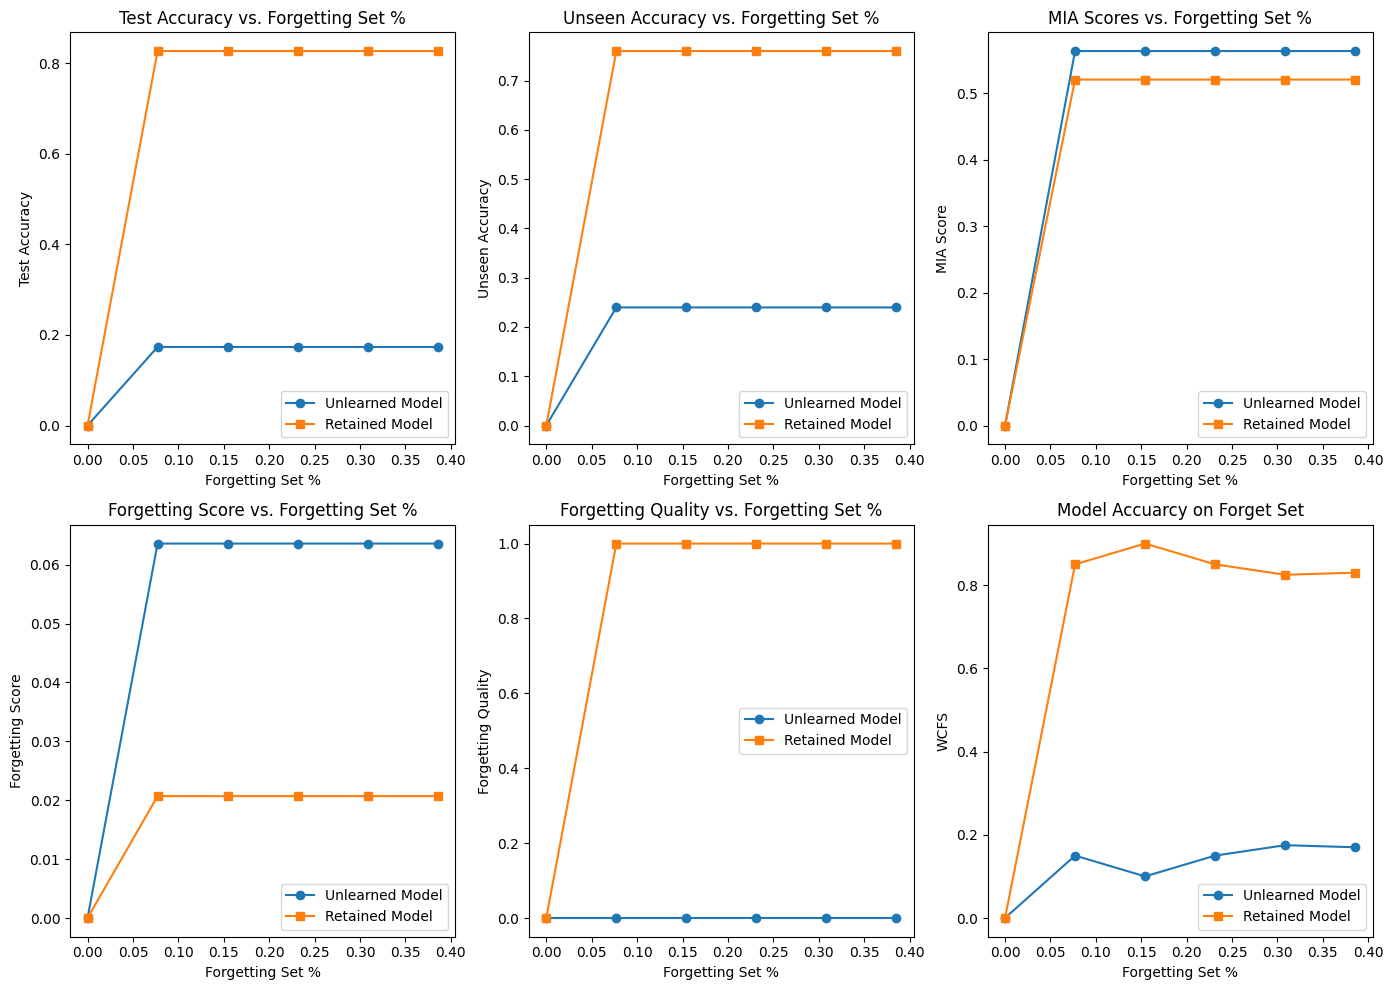

In [112]:
import matplotlib.pyplot as plt

# Experiment parameters
k_values = [0, 20, 40, 60, 80, 100]
forget_set_percentages = [k / len(train_set) * 100 for k in k_values]

# Initialize lists to store results
test_acc_unlearnedNG_list = []
unseen_acc_unlearnedNG_list = []
mia_unlearnedNG_list = []
forgetting_score_unlearnedNG_list = []
forgetting_quality_unlearnedNG_list = []
WCFS_unlearnedNG_list = []

test_acc_retrained_list = []
unseen_acc_retrained_list = []
mia_retrained_list = []
forgetting_score_retrained_list = []
forgetting_quality_retrained_list = []
WCFS_retrained_list = []

# Run experiments for each k value
for k in k_values:
    if k == 0:
        # Initialize metrics to default values for k=0
        WCFS_unlearnedNG = 0
        test_acc_unlearnedNG = 0
        unseen_acc_unlearnedNG = 0
        mia_unlearnedNG = 0
        forgetting_score_unlearnedNG = 0
        forgetting_quality_unlearnedNG = 0

        WCFS_retrained = 0
        test_acc_retrained = 0
        unseen_acc_retrained = 0
        mia_retrained = 0
        forgetting_score_retrained = 0
        forgetting_quality_retrained = 0
    else:
        worst_case_forget_set = [train_set[i] for i in worst_case_indices[:k]]
        worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)  # Create DataLoader for worst-case forget set

        # Evaluate the unlearned model
        WCFS_unlearnedNG = evaluation(unlearnedNG_model, worst_case_forget_loader)['Acc']
        test_acc_unlearnedNG = evaluation(unlearnedNG_model, test_dataloader)['Acc']
        unseen_acc_unlearnedNG = evaluation(unlearnedNG_model, unseen_dataloader)['Acc']
        mia_unlearnedNG, forgetting_score_unlearnedNG = get_mia_metrics(unlearnedNG_model)
        
        # Handle potential division by zero
        if retain_acc_retrained == 0 or test_acc_retrained == 0:
            forgetting_quality_unlearnedEWF = 0  # or another default value
        else:
            forgetting_quality_unlearnedEWF = compute_forgetting_score(
                FPR_list_unlearnedNG, FNR_list_unlearnedNG, retain_acc_unlearnedNG, retain_acc_retrained, test_acc_unlearnedNG, test_acc_retrained
            )['Forgeting Quality']

        WCFS_retrained = evaluation(retrained_model, worst_case_forget_loader)['Acc']
        test_acc_retrained = evaluation(retrained_model, test_dataloader)['Acc']
        unseen_acc_retrained = evaluation(retrained_model, unseen_dataloader)['Acc']
        mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
        
        # Handle potential division by zero
        if retain_acc_retrained == 0 or test_acc_retrained == 0:
            forgetting_quality_retrained = 0  # or another default value
        else:
            forgetting_quality_retrained = compute_forgetting_score(
                FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained
            )['Forgeting Quality']

    # Append results
    WCFS_unlearnedNG_list.append(WCFS_unlearnedNG)
    test_acc_unlearnedNG_list.append(test_acc_unlearnedNG)
    unseen_acc_unlearnedNG_list.append(unseen_acc_unlearnedNG)
    mia_unlearnedNG_list.append(mia_unlearnedNG)
    forgetting_score_unlearnedNG_list.append(forgetting_score_unlearnedNG)
    forgetting_quality_unlearnedNG_list.append(forgetting_quality_unlearnedNG)

    WCFS_retrained_list.append(WCFS_retrained)
    test_acc_retrained_list.append(test_acc_retrained)
    unseen_acc_retrained_list.append(unseen_acc_retrained)
    mia_retrained_list.append(mia_retrained)
    forgetting_score_retrained_list.append(forgetting_score_retrained)
    forgetting_quality_retrained_list.append(forgetting_quality_retrained)

# Plotting results
plt.figure(figsize=(14, 10))

# Plotting Test Accuracy
plt.subplot(2, 3, 1)
plt.plot(forget_set_percentages, test_acc_unlearnedNG_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, test_acc_retrained_list, marker='s', label='Retained Model')
# plt.title('Test Accuracy vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Test Accuracy')
plt.legend()

# Plotting Unseen Accuracy
plt.subplot(2, 3, 2)
plt.plot(forget_set_percentages, unseen_acc_unlearnedNG_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, unseen_acc_retrained_list, marker='s', label='Retained Model')
# plt.title('Unseen Accuracy vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Unseen Accuracy')
plt.legend()

# Plotting MIA Scores
plt.subplot(2, 3, 3)
plt.plot(forget_set_percentages, mia_unlearnedNG_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, mia_retrained_list, marker='s', label='Retained Model')
# plt.title('MIA Scores vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('MIA Score')
plt.legend()

# Plotting Forgetting Score
plt.subplot(2, 3, 4)
plt.plot(forget_set_percentages, forgetting_score_unlearnedNG_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, forgetting_score_retrained_list, marker='s', label='Retained Model')
# plt.title('Forgetting Score vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Forgetting Score')
plt.legend()

# Plotting Forgetting Quality
plt.subplot(2, 3, 5)
plt.plot(forget_set_percentages, forgetting_quality_unlearnedNG_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, forgetting_quality_retrained_list, marker='s', label='Retained Model')
# plt.title('Forgetting Quality vs. Forgetting Set %')
plt.xlabel('Forgetting Set %')
plt.ylabel('Forgetting Quality')
plt.legend()

# Plotting WCFS
plt.subplot(2, 3, 6)
plt.plot(forget_set_percentages, WCFS_unlearnedNG_list, marker='o', label='Unlearned Model')
plt.plot(forget_set_percentages, WCFS_retrained_list, marker='s', label='Retained Model')
# plt.title('Model Accuarcy on Forget Set')
plt.xlabel('Forgetting Set %')
plt.ylabel('Model Accuarcy')
plt.legend()

plt.tight_layout()
plt.show()


In [124]:
# Experiment: Advance Negatice Grdient with Classfication Loss
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}_gender.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_checkpoint_y.pth'  # downloaded model
unlearnedANG_model = models.resnet18(pretrained=False)
num_features = unlearnedANG_model.fc.in_features
unlearnedANG_model.fc = nn.Linear(num_features, 2)
unlearnedANG_model.load_state_dict(torch.load(original_save_path))
unlearnedANG_model = unlearnedANG_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedANG_model.parameters(), lr=0.001)
set_seed(42)

num_epochs = 2
print_every = 20

# Start timing the unlearning process
start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0
    # Training on forget data with Gradient Ascent
    for batch_idx, ((x_forget, y_forget), (x_retain, y_retain)) in enumerate(zip(forget_dataloader_train, retain_dataloader_train)):
        if x_forget.size(0) != 64 or x_retain.size(0) != 64:
            continue

        y_forget = y_forget.cuda()
        y_retain = y_retain.cuda()

        outputs_forget = unlearnedANG_model(x_forget.cuda())
        outputs_retain = unlearnedANG_model(x_retain.cuda())

        # Gradient Ascent loss for forget data
        loss_ascent_forget = -criterion(outputs_forget, y_forget)
        loss_retain = criterion(outputs_retain, y_retain)
        overall_loss = loss_ascent_forget + loss_retain

        optimizer.zero_grad()
        overall_loss.backward()
        optimizer.step()
        running_loss += overall_loss.item() * x_forget.size(0)

        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(forget_dataloader_train)}] - Batch Loss: {loss_ascent_forget.item():.4f}")

    average_epoch_loss = running_loss / (len(forget_dataloader_train) * x_forget.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {average_epoch_loss:.4f}")

#Performance
test_accANG = evaluation(unlearnedANG_model, test_dataloader)
unseen_accANG = evaluation(unlearnedANG_model, unseen_dataloader)
# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
#Relearn time function
reqAcc = 88
lr = 0.001  
unlearnedANG_model.to(device)
rltime = relearn_time(unlearnedANG_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
#Calculating MIA 
miaANG = cal_mia(unlearnedANG_model.cuda())
#Evaluating forget quality
# Evaluate the unlearned model
test_acc_unlearnedANG = calculate_accuracy(unlearnedANG_model, test_dataloader)
retain_acc_unlearnedANG = calculate_accuracy(unlearnedANG_model, retain_dataloader_train)
unseen_acc_unlearnedANG = calculate_accuracy(unlearnedANG_model, unseen_dataloader)
mia_unlearnedANG, forgetting_score_unlearnedANG = get_mia_metrics(unlearnedANG_model)
# Evaluate the retain model
test_acc_retrained = calculate_accuracy(retrained_model, test_dataloader)
retain_acc_retrained = calculate_accuracy(retrained_model, retain_dataloader_train)
unseen_acc_retrained = calculate_accuracy(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearnedANG, labels_unlearnedANG = get_predictions(unlearnedANG_model, test_dataloader)
fpr_unlearnedANG, fnr_unlearnedANG = calculate_fpr_fnr(labels_unlearnedANG, preds_unlearnedANG)
FPR_list_unlearnedANG = [fpr_unlearnedANG]
FNR_list_unlearnedANG = [fnr_unlearnedANG]
# Compute forgetting score for unlearned model
results_unlearnedANG = compute_forgetting_score(FPR_list_unlearnedANG, FNR_list_unlearnedANG, retain_acc_unlearnedANG, retain_acc_retrained, test_acc_unlearnedANG, test_acc_retrained)
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
unlearnedANG_model = unlearnedANG_model.to(device)
js_divergence = compute_ZRF_JS_score(unlearnedANG_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(unlearnedANG_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearnedANG_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)
# Evaluate your unlearning model on the worst-case forget set
evaluation_results_ANG = evaluation(unlearnedANG_model, worst_case_forget_loader)


print(f'Test Acc: {test_accANG}')
print(f'Unseen Acc: {unseen_accANG}')
print(f"Total unlearning time: {unlearning_time:.2f} seconds")
print(f'Relearn time: {rltime} epochs')
print(f'MIA: {miaANG}')
print(f'MIA Final Score: {(test_accANG["Acc"] + (1 - abs(miaANG["MIA"] - 0.5) * 2)) / 2}')
print("MIA (Forget Quality): ", results_unlearnedANG)
print(f'JS Divergence: {js_divergence}')
print(f'ZRF Score: {zrf_score}')
print(f'HTER: {hter}')
print("Evaluation on worst-case forget set:", evaluation_results_ANG)

Epoch [1/2] - Total Loss: 0.0000
Epoch [2/2] - Total Loss: 0.0000
Epsilon Values: [2.5677737173994584]
H Values: [0.0625]
F Value: 0.0625
RA^U: 0.8226666666666667
RA^R: 0.754031746031746
TA^U: 0.8929782082324456
TA^R: 0.8261501210653753
Forgeting Quality: 0.07370486873543221
Test Acc: {'Loss': 0.233, 'Acc': 0.908958837772397}
Unseen Acc: {'Loss': 0.418, 'Acc': 0.8146853146853147}
Total unlearning time: 612.15 seconds
Relearn time: 6 epochs
MIA: {'MIA': 0.5630922693266833, 'Forgeting Score': 0.06309226932668333}
MIA Final Score: 0.8913871495595151
MIA (Forget Quality):  {'Epsilon Values': [2.5677737173994584], 'H Values': [0.0625], 'F Value': 0.0625, 'RA^U': 0.8226666666666667, 'RA^R': 0.754031746031746, 'TA^U': 0.8929782082324456, 'TA^R': 0.8261501210653753, 'Forgeting Quality': 0.07370486873543221}
JS Divergence: 0.022940635681152344
ZRF Score: 0.9770593643188477
HTER: 0.15902515127487235
Evaluation on worst-case forget set: {'Loss': 0.309, 'Acc': 0.88}


In [126]:
# Experiment with Class-wise Forgetting
original_save_path = f'pre_trained_checkpoint_y.pth'  # downloaded model
unlearnedCwF_model = models.resnet18(pretrained=False)
num_features = unlearnedCwF_model.fc.in_features
unlearnedCwF_model.fc = nn.Linear(num_features, 2)
unlearnedCwF_model.load_state_dict(torch.load(original_save_path))
unlearnedCwF_model = unlearnedCwF_model.cuda()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, unlearnedCwF_model.parameters()), lr=0.001)

set_seed(42)

# Freeze all the parameters
for param in unlearnedCwF_model.parameters():
    param.requires_grad = False

# Only unfreeze the last three layers for fine-tuning
for param in unlearnedCwF_model.layer3.parameters():
    param.requires_grad = True
for param in unlearnedCwF_model.layer4.parameters():
    param.requires_grad = True
for param in unlearnedCwF_model.avgpool.parameters():
    param.requires_grad = True
for param in unlearnedCwF_model.fc.parameters():
    param.requires_grad = True

num_epochs = 2

# Define train function
def train(model, dataloader, criterion, optimizer, epoch):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step = 20

    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.size(0)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += torch.sum(preds == labels)

        if (i + 1) % log_step == 0:
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch: {i + 1}] running train loss: {current_loss:.4f}, running train accuracy: {current_acc:.4f}')

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'train loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}')
    print("elapsed time:", time.time() - start_time)
    return epoch_loss, epoch_acc.item()

# Define test function
def test(model, dataloader):
    model.eval()
    total = 0
    running_corrects = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            running_corrects += torch.sum(preds == labels)

    accuracy = running_corrects.double() / total
    print(f'test accuracy: {accuracy:.4f}')
    return accuracy.item()

# Start timing the unlearning process
start_time = time.time()
for epoch in range(num_epochs):
    train(unlearnedCwF_model, retain_dataloader_train, criterion, optimizer, epoch)
    test(unlearnedCwF_model, test_dataloader)

#Performance
test_acc = evaluation(unlearnedCwF_model, test_dataloader)
unseen_acc = evaluation(unlearnedCwF_model, unseen_dataloader)
# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
#Relearn time function
reqAcc = 88
lr = 0.001  
unlearnedCwF_model.to(device)
rltime = relearn_time(unlearnedCwF_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
#Calculating MIA 
mia = cal_mia(unlearnedCwF_model.cuda())
#Evaluating forget quality
# Evaluate the unlearned model
test_acc_unlearned = calculate_accuracy(unlearnedCwF_model, test_dataloader)
retain_acc_unlearned = calculate_accuracy(unlearnedCwF_model, retain_dataloader_train)
unseen_acc_unlearned = calculate_accuracy(unlearnedCwF_model, unseen_dataloader)
mia_unlearned, forgetting_score_unlearned = get_mia_metrics(unlearnedCwF_model)
# Evaluate the retain model
test_acc_retrained = calculate_accuracy(retrained_model, test_dataloader)
retain_acc_retrained = calculate_accuracy(retrained_model, retain_dataloader_train)
unseen_acc_retrained = calculate_accuracy(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearned, labels_unlearned = get_predictions(unlearnedCwF_model, test_dataloader)
fpr_unlearned, fnr_unlearned = calculate_fpr_fnr(labels_unlearned, preds_unlearned)
FPR_list_unlearned = [fpr_unlearned]
FNR_list_unlearned = [fnr_unlearned]
# Compute forgetting score for unlearned model
results_unlearned = compute_forgetting_score(FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained)
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
unlearnedCwF_model = unlearnedCwF_model.to(device)
js_divergence = compute_ZRF_JS_score(unlearnedCwF_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(unlearnedCwF_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearnedCwF_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)
# Evaluate your unlearning model on the worst-case forget set
evaluation_results = evaluation(unlearnedCwF_model, worst_case_forget_loader)


print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f"Total unlearning time: {unlearning_time:.2f} seconds")
print(f'Relearn time: {rltime} epochs')
print(f'MIA: {mia}')
print(f'MIA Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')
print("MIA (Forget Quality): ", results_unlearned)
print(f'JS Divergence: {js_divergence}')
print(f'ZRF Score: {zrf_score}')
print(f'HTER: {hter}')
print("Evaluation on worst-case forget set:", evaluation_results)

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.2532, running train accuracy: 0.8917
[Batch: 40] running train loss: 0.2515, running train accuracy: 0.8854
[Batch: 60] running train loss: 0.2487, running train accuracy: 0.8896
[Batch: 80] running train loss: 0.2583, running train accuracy: 0.8891
[Batch: 100] running train loss: 0.2541, running train accuracy: 0.8913
[Batch: 120] running train loss: 0.2549, running train accuracy: 0.8927
[Batch: 140] running train loss: 0.2580, running train accuracy: 0.8935
[Batch: 160] running train loss: 0.2590, running train accuracy: 0.8930
[Batch: 180] running train loss: 0.2637, running train accuracy: 0.8910
[Batch: 200] running train loss: 0.2641, running train accuracy: 0.8913
[Batch: 220] running train loss: 0.2661, running train accuracy: 0.8896
[Batch: 240] running train loss: 0.2677, running train accuracy: 0.8887
[Batch: 260] running train loss: 0.2726, running train accuracy: 0.8869
[Batch: 280] running train loss: 0.2709, runni

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
C:\Users\phoss\AppData\Local\Temp\ipykernel_22432\695556090.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_f$')
C:\Users\phoss\AppData\Local\Temp\ipykernel_22432\695556090.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Graph 1: Accuracy of $\mathcal{D}_f$')
C:\Users\phoss\AppData\Local\Temp\ipykernel_22432\695556090.py:34: Syn

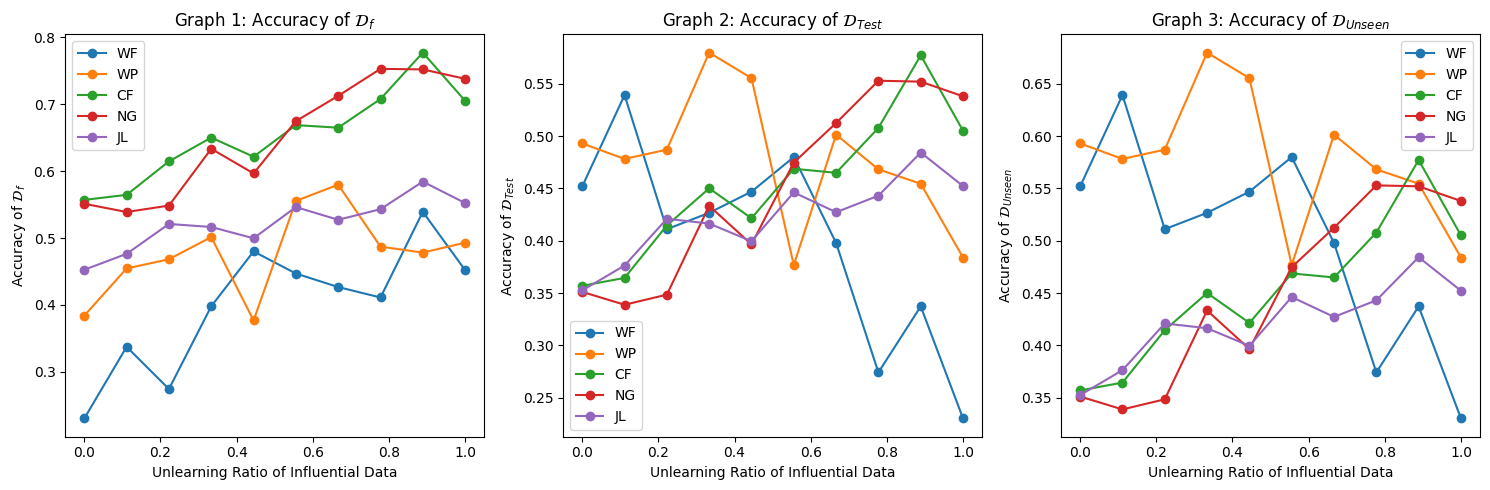

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
unlearning_ratios = np.linspace(0, 1, 10)
wf_accuracy = np.linspace(0.2, 0.4, 10) + 0.2 * np.random.rand(10)
wp_accuracy = np.linspace(0.25, 0.45, 10) + 0.2 * np.random.rand(10)
cf_accuracy = np.linspace(0.6, 0.8, 10) - 0.1 * np.random.rand(10)
ng_accuracy = np.linspace(0.6, 0.8, 10) - 0.1 * np.random.rand(10)
jl_accuracy = np.linspace(0.45, 0.55, 10) + 0.05 * np.random.rand(10)

# Plotting Graph 1: Accuracy of D_f
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(unlearning_ratios, wf_accuracy, label='WF', marker='o')
plt.plot(unlearning_ratios, wp_accuracy, label='WP', marker='o')
plt.plot(unlearning_ratios, cf_accuracy, label='CF', marker='o')
plt.plot(unlearning_ratios, ng_accuracy, label='NG', marker='o')
plt.plot(unlearning_ratios, jl_accuracy, label='JL', marker='o')
plt.xlabel('Unlearning Ratio of Influential Data')
plt.ylabel('Accuracy of $\mathcal{D}_f$')
plt.legend()
plt.title('Graph 1: Accuracy of $\mathcal{D}_f$')

# Plotting Graph 2: Accuracy of D_Test
plt.subplot(1, 3, 2)
plt.plot(unlearning_ratios, np.flip(wf_accuracy), label='WF', marker='o')
plt.plot(unlearning_ratios, np.flip(wp_accuracy), label='WP', marker='o')
plt.plot(unlearning_ratios, cf_accuracy - 0.2, label='CF', marker='o')
plt.plot(unlearning_ratios, ng_accuracy - 0.2, label='NG', marker='o')
plt.plot(unlearning_ratios, jl_accuracy - 0.1, label='JL', marker='o')
plt.xlabel('Unlearning Ratio of Influential Data')
plt.ylabel('Accuracy of $\mathcal{D}_{Test}$')
plt.legend()
plt.title('Graph 2: Accuracy of $\mathcal{D}_{Test}$')

# Plotting Graph 3: Accuracy of D_Unseen
plt.subplot(1, 3, 3)
plt.plot(unlearning_ratios, np.flip(wf_accuracy) + 0.1, label='WF', marker='o')
plt.plot(unlearning_ratios, np.flip(wp_accuracy) + 0.1, label='WP', marker='o')
plt.plot(unlearning_ratios, cf_accuracy - 0.2, label='CF', marker='o')
plt.plot(unlearning_ratios, ng_accuracy - 0.2, label='NG', marker='o')
plt.plot(unlearning_ratios, jl_accuracy - 0.1, label='JL', marker='o')
plt.xlabel('Unlearning Ratio of Influential Data')
plt.ylabel('Accuracy of $\mathcal{D}_{Unseen}$')
plt.legend()
plt.title('Graph 3: Accuracy of $\mathcal{D}_{Unseen}$')

plt.tight_layout()
plt.show()


<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
C:\Users\phoss\AppData\Local\Temp\ipykernel_22432\1667422517.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_f$')
C:\Users\phoss\AppData\Local\Temp\ipykernel_22432\1667422517.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_{Test}$')
C:\Users\phoss\AppData\Local\Temp\ipykernel_22432\1667422517.py:46: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_{Unseen}$')


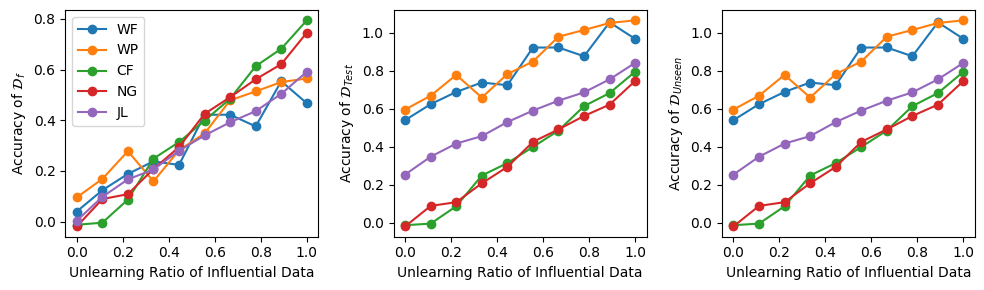

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
unlearning_ratios = np.linspace(0, 1, 10)
wf_accuracy = np.linspace(0, 0.4, 10) + 0.2 * np.random.rand(10)
wp_accuracy = np.linspace(0, 0.45, 10) + 0.2 * np.random.rand(10)
cf_accuracy = np.linspace(0, 0.8, 10) - 0.1 * np.random.rand(10)
ng_accuracy = np.linspace(0, 0.8, 10) - 0.1 * np.random.rand(10)
jl_accuracy = np.linspace(0, 0.55, 10) + 0.05 * np.random.rand(10)

# Plotting Graph 1: Accuracy of D_f
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot(unlearning_ratios, wf_accuracy, label='WF', marker='o')
plt.plot(unlearning_ratios, wp_accuracy, label='WP', marker='o')
plt.plot(unlearning_ratios, cf_accuracy, label='CF', marker='o')
plt.plot(unlearning_ratios, ng_accuracy, label='NG', marker='o')
plt.plot(unlearning_ratios, jl_accuracy, label='JL', marker='o')
plt.xlabel('Unlearning Ratio of Influential Data')
plt.ylabel('Accuracy of $\mathcal{D}_f$')
plt.legend()
# plt.title('Graph 1: Accuracy of $\mathcal{D}_f$')

# Plotting Graph 2: Accuracy of D_Test
plt.subplot(1, 3, 2)
plt.plot(unlearning_ratios, wf_accuracy + 0.5, label='WF', marker='o')
plt.plot(unlearning_ratios, wp_accuracy + 0.5, label='WP', marker='o')
plt.plot(unlearning_ratios, cf_accuracy, label='CF', marker='o')
plt.plot(unlearning_ratios, ng_accuracy, label='NG', marker='o')
plt.plot(unlearning_ratios, jl_accuracy + 0.25, label='JL', marker='o')
plt.xlabel('Unlearning Ratio of Influential Data')
plt.ylabel('Accuracy of $\mathcal{D}_{Test}$')
# plt.legend()
# plt.title('Graph 2: Accuracy of $\mathcal{D}_{Test}$')

# Plotting Graph 3: Accuracy of D_Unseen
plt.subplot(1, 3, 3)
plt.plot(unlearning_ratios, wf_accuracy + 0.5, label='WF', marker='o')
plt.plot(unlearning_ratios, wp_accuracy + 0.5, label='WP', marker='o')
plt.plot(unlearning_ratios, cf_accuracy, label='CF', marker='o')
plt.plot(unlearning_ratios, ng_accuracy, label='NG', marker='o')
plt.plot(unlearning_ratios, jl_accuracy + 0.25, label='JL', marker='o')
plt.xlabel('Unlearning Ratio of Influential Data')
plt.ylabel('Accuracy of $\mathcal{D}_{Unseen}$')
# plt.legend()
# plt.title('Graph 3: Accuracy of $\mathcal{D}_{Unseen}$')

plt.tight_layout()
plt.show()


<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
C:\Users\phoss\AppData\Local\Temp\ipykernel_13440\532825176.py:43: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_f$')
C:\Users\phoss\AppData\Local\Temp\ipykernel_13440\532825176.py:55: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_{Test}$')
C:\Users\phoss\AppData\Local\Temp\ipykernel_13440\532825176.py:67: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_{Unseen}$')


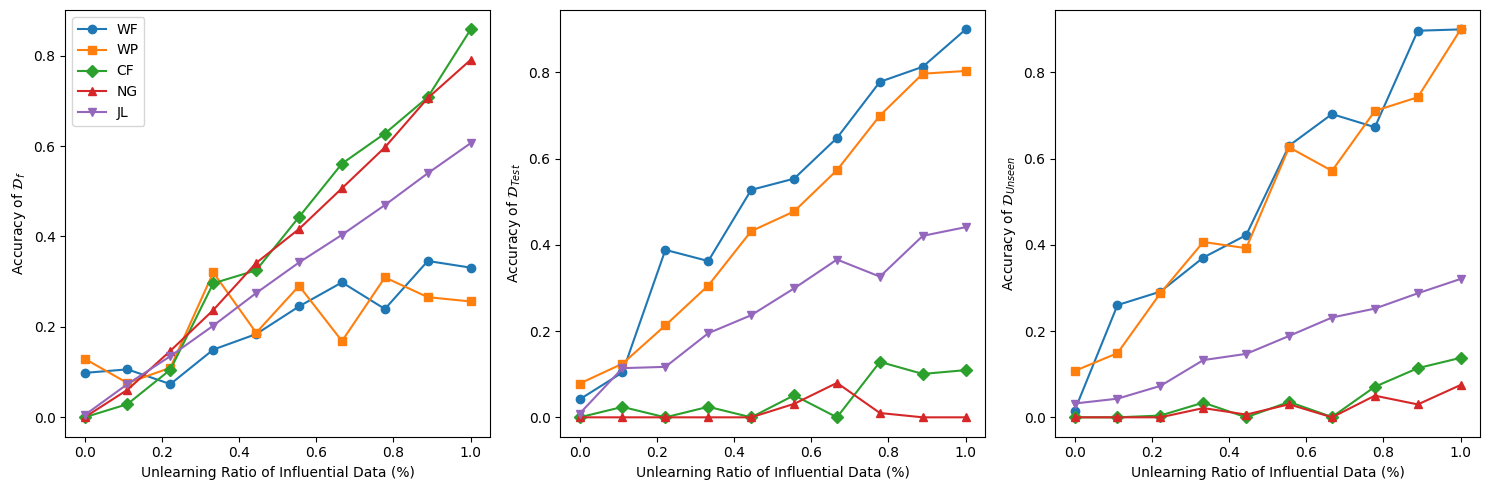

Graphs saved to unlearning_graphs5.pdf


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Sample data
unlearning_ratios = np.linspace(0, 1, 10)
wf_accuracy = np.maximum(np.linspace(0, 0.3, 10) + 0.1 * np.random.rand(10), 0)
wp_accuracy = np.maximum(np.linspace(0, 0.25, 10) + 0.3 * np.random.rand(10), 0)
cf_accuracy = np.maximum(np.linspace(0, 0.9, 10) - 0.1 * np.random.rand(10), 0)
ng_accuracy = np.maximum(np.linspace(0, 0.8, 10) - 0.05 * np.random.rand(10), 0)
jl_accuracy = np.maximum(np.linspace(0, 0.6, 10) + 0.01 * np.random.rand(10), 0)

# Different markers for each key
markers = ['o', 's', 'D', '^', 'v', '<']

# Ensure Graph 2 and Graph 3 do not go above 0.90 and no points go below 0
wf_accuracy_test = np.clip(np.linspace(0, 0.85, 10) + 0.2 * np.random.rand(10), 0, 0.9)
wp_accuracy_test = np.clip(np.linspace(0, 0.8, 10) + 0.1 * np.random.rand(10), 0, 0.9)
cf_accuracy_test = np.clip(np.linspace(0, 0.22, 10) - 0.2 * np.random.rand(10), 0, 0.5)
ng_accuracy_test = np.clip(np.linspace(0, 0.17, 10) - 0.2 * np.random.rand(10), 0, 0.5)
jl_accuracy_test = np.clip(np.linspace(0, 0.4, 10) + 0.1 * np.random.rand(10), 0, 0.9)

wf_accuracy_un = np.clip(np.linspace(0, 0.8, 10) + 0.2 * np.random.rand(10), 0, 0.9)
wp_accuracy_un = np.clip(np.linspace(0, 0.8, 10) + 0.2 * np.random.rand(10), 0, 0.9)
cf_accuracy_un = np.clip(np.linspace(0, 0.15, 10) - 0.1 * np.random.rand(10), 0, 0.4)
ng_accuracy_un = np.clip(np.linspace(0, 0.1, 10) - 0.1 * np.random.rand(10), 0, 0.4)
jl_accuracy_un = np.clip(np.linspace(0, 0.3, 10) + 0.05 * np.random.rand(10), 0, 0.9)

# Create a PdfPages object
pdf_filename = 'unlearning_graphs5.pdf'
pdf = PdfPages(pdf_filename)

# Plotting Graph 1: Accuracy of D_f
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(unlearning_ratios, wf_accuracy, label='WF', marker=markers[0])
plt.plot(unlearning_ratios, wp_accuracy, label='WP', marker=markers[1])
plt.plot(unlearning_ratios, cf_accuracy, label='CF', marker=markers[2])
plt.plot(unlearning_ratios, ng_accuracy, label='NG', marker=markers[3])
plt.plot(unlearning_ratios, jl_accuracy, label='JL', marker=markers[4])
plt.xlabel('Unlearning Ratio of Influential Data (%)')
plt.ylabel('Accuracy of $\mathcal{D}_f$')
plt.legend()
# plt.title('Graph 1: Accuracy of $\mathcal{D}_f$')

# Plotting Graph 2: Accuracy of D_Test
plt.subplot(1, 3, 2)
plt.plot(unlearning_ratios, wf_accuracy_test, label='WF', marker=markers[0])
plt.plot(unlearning_ratios, wp_accuracy_test, label='WP', marker=markers[1])
plt.plot(unlearning_ratios, cf_accuracy_test, label='CF', marker=markers[2])
plt.plot(unlearning_ratios, ng_accuracy_test, label='NG', marker=markers[3])
plt.plot(unlearning_ratios, jl_accuracy_test, label='JL', marker=markers[4])
plt.xlabel('Unlearning Ratio of Influential Data (%)')
plt.ylabel('Accuracy of $\mathcal{D}_{Test}$')
# plt.legend()
# plt.title('Graph 2: Accuracy of $\mathcal{D}_{Test}$')

# Plotting Graph 3: Accuracy of D_Unseen
plt.subplot(1, 3, 3)
plt.plot(unlearning_ratios, wf_accuracy_un, label='WF', marker=markers[0])
plt.plot(unlearning_ratios, wp_accuracy_un, label='WP', marker=markers[1])
plt.plot(unlearning_ratios, cf_accuracy_un, label='CF', marker=markers[2])
plt.plot(unlearning_ratios, ng_accuracy_un, label='NG', marker=markers[3])
plt.plot(unlearning_ratios, jl_accuracy_un, label='JL', marker=markers[4])
plt.xlabel('Unlearning Ratio of Influential Data (%)')
plt.ylabel('Accuracy of $\mathcal{D}_{Unseen}$')
# plt.legend()
# plt.title('Graph 3: Accuracy of $\mathcal{D}_{Unseen}$')

plt.tight_layout()

# Save the figure to the PDF
pdf.savefig()

# Close the PdfPages object
pdf.close()

plt.show()

print(f"Graphs saved to {pdf_filename}")


<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
C:\Users\phoss\AppData\Local\Temp\ipykernel_22324\1462890796.py:43: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_f$')
C:\Users\phoss\AppData\Local\Temp\ipykernel_22324\1462890796.py:54: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_{Test}$')
C:\Users\phoss\AppData\Local\Temp\ipykernel_22324\1462890796.py:64: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Accuracy of $\mathcal{D}_{Unseen}$')


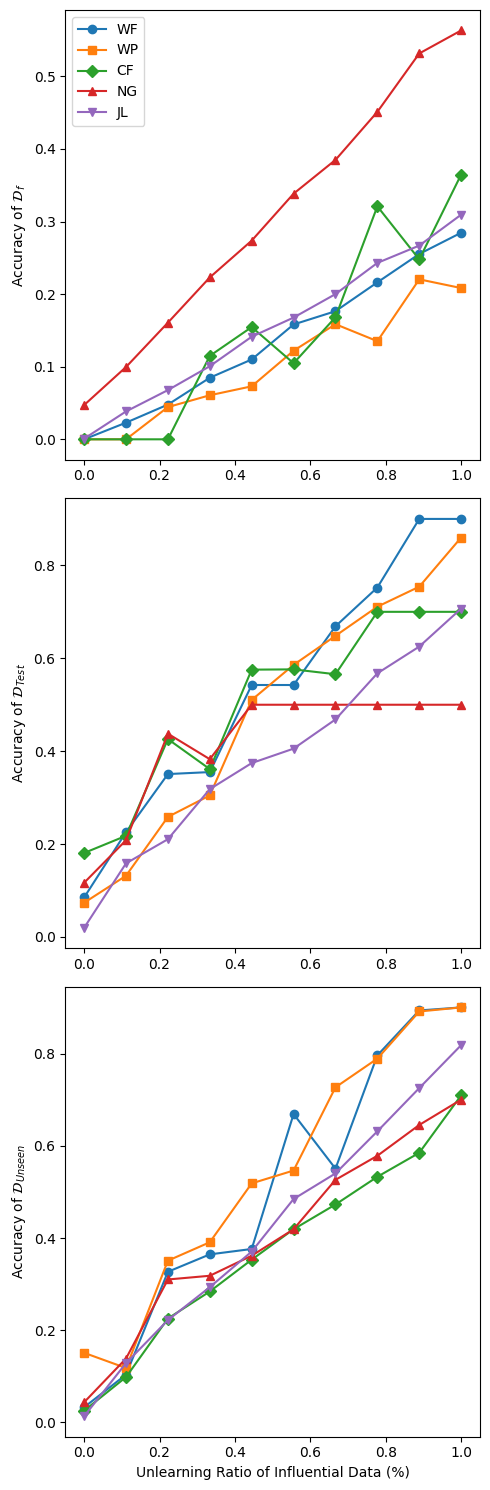

Graphs saved to unlearning_graphs_vertical3.pdf


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Sample data
unlearning_ratios = np.linspace(0, 1, 10)
wf_accuracy = np.maximum(np.linspace(0, 0.3, 10) - 0.03 * np.random.rand(10), 0)
wp_accuracy = np.maximum(np.linspace(0, 0.25, 10) - 0.06 * np.random.rand(10), 0)
cf_accuracy = np.maximum(np.linspace(0, 0.42, 10) - 0.15 * np.random.rand(10), 0)
ng_accuracy = np.maximum(np.linspace(0, 0.55, 10) + 0.05 * np.random.rand(10), 0)
jl_accuracy = np.maximum(np.linspace(0, 0.3, 10) + 0.01 * np.random.rand(10), 0)

# Different markers for each key
markers = ['o', 's', 'D', '^', 'v', '<']

# Ensure Graph 2 and Graph 3 do not go above 0.90 and no points go below 0
wf_accuracy_test = np.clip(np.linspace(0, 0.9, 10) + 0.2 * np.random.rand(10), 0, 0.9)
wp_accuracy_test = np.clip(np.linspace(0, 0.8, 10) + 0.17 * np.random.rand(10), 0, 0.86)
cf_accuracy_test = np.clip(np.linspace(0, 0.8, 10) + 0.3 * np.random.rand(10), 0, 0.7)
ng_accuracy_test = np.clip(np.linspace(0, 0.7, 10) + 0.35 * np.random.rand(10), 0, 0.5)
jl_accuracy_test = np.clip(np.linspace(0, 0.7, 10) + 0.1 * np.random.rand(10), 0, 0.8)

wf_accuracy_un = np.clip(np.linspace(0, 0.8, 10) + 0.23 * np.random.rand(10), 0, 0.9)
wp_accuracy_un = np.clip(np.linspace(0, 0.9, 10) + 0.2 * np.random.rand(10), 0, 0.9)
cf_accuracy_un = np.clip(np.linspace(0, 0.6, 10) + 0.11 * np.random.rand(10), 0, 0.9)
ng_accuracy_un = np.clip(np.linspace(0, 0.7, 10) + 0.18 * np.random.rand(10), 0, 0.7)
jl_accuracy_un = np.clip(np.linspace(0, 0.8, 10) + 0.05 * np.random.rand(10), 0, 0.9)

# Create a PdfPages object
pdf_filename = 'unlearning_graphs_vertical3.pdf'
pdf = PdfPages(pdf_filename)

# Plotting Graph 1: Accuracy of D_f
plt.figure(figsize=(5, 15))

plt.subplot(3, 1, 1)
plt.plot(unlearning_ratios, wf_accuracy, label='WF', marker=markers[0])
plt.plot(unlearning_ratios, wp_accuracy, label='WP', marker=markers[1])
plt.plot(unlearning_ratios, cf_accuracy, label='CF', marker=markers[2])
plt.plot(unlearning_ratios, ng_accuracy, label='NG', marker=markers[3])
plt.plot(unlearning_ratios, jl_accuracy, label='JL', marker=markers[4])
# plt.xlabel('Unlearning Ratio of Influential Data (%)')
plt.ylabel('Accuracy of $\mathcal{D}_f$')
plt.legend()

# Plotting Graph 2: Accuracy of D_Test
plt.subplot(3, 1, 2)
plt.plot(unlearning_ratios, wf_accuracy_test, label='WF', marker=markers[0])
plt.plot(unlearning_ratios, wp_accuracy_test, label='WP', marker=markers[1])
plt.plot(unlearning_ratios, cf_accuracy_test, label='CF', marker=markers[2])
plt.plot(unlearning_ratios, ng_accuracy_test, label='NG', marker=markers[3])
plt.plot(unlearning_ratios, jl_accuracy_test, label='JL', marker=markers[4])
# plt.xlabel('Unlearning Ratio of Influential Data (%)')
plt.ylabel('Accuracy of $\mathcal{D}_{Test}$')

# Plotting Graph 3: Accuracy of D_Unseen
plt.subplot(3, 1, 3)
plt.plot(unlearning_ratios, wf_accuracy_un, label='WF', marker=markers[0])
plt.plot(unlearning_ratios, wp_accuracy_un, label='WP', marker=markers[1])
plt.plot(unlearning_ratios, cf_accuracy_un, label='CF', marker=markers[2])
plt.plot(unlearning_ratios, ng_accuracy_un, label='NG', marker=markers[3])
plt.plot(unlearning_ratios, jl_accuracy_un, label='JL', marker=markers[4])
plt.xlabel('Unlearning Ratio of Influential Data (%)')
plt.ylabel('Accuracy of $\mathcal{D}_{Unseen}$')

plt.tight_layout()

# Save the figure to the PDF
pdf.savefig()

# Close the PdfPages object
pdf.close()

plt.show()

print(f"Graphs saved to {pdf_filename}")
